In [40]:
from models import LMS, KLMS, KAPA
from evaluation import evaluate_online, calculate_directional_symmetry
from data_processing import prepare_stock_data, create_stream
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
import yfinance as yf
import pandas as pd

### Data loading

In [42]:
nifty = yf.download('^NSEI', start='2019-01-01', end='2022-05-31', interval='1d')
print(nifty.head())

# For intraday data (1 minute, 5 minutes, etc.)
# Note: Limited to last 7-30 days for minute data
nifty_1m = yf.download('^NSEI', period='7d', interval='1m')
nifty_5m = yf.download('^NSEI', period='60d', interval='5m')
nifty_60m = yf.download('^NSEI', period='730d', interval='60m')

# Calculate mid-price
nifty['MidPrice_HL'] = (nifty['High'] + nifty['Low']) / 2
nifty['MidPrice_OC'] = (nifty['Open'] + nifty['Close']) / 2

print(f"Data shape: {nifty.shape}")
print(nifty.columns)

[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI
Date                                                                      
2019-01-02  10792.500000  10895.349609  10735.049805  10868.849609  309700
2019-01-03  10672.250000  10814.049805  10661.250000  10796.799805  286200
2019-01-04  10727.349609  10741.049805  10628.650391  10699.700195  296600
2019-01-07  10771.799805  10835.950195  10750.150391  10804.849609  269400
2019-01-08  10802.150391  10818.450195  10733.250000  10786.250000  277700


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data shape: (839, 7)
MultiIndex([(      'Close', '^NSEI'),
            (       'High', '^NSEI'),
            (        'Low', '^NSEI'),
            (       'Open', '^NSEI'),
            (     'Volume', '^NSEI'),
            ('MidPrice_HL',      ''),
            ('MidPrice_OC',      '')],
           names=['Price', 'Ticker'])


## Data processing 

In [6]:
ticker = "TITAN.NS"
titan_1d_data=data_1d = yf.download(ticker, start='2021-01-01', end='2021-05-31', 
                          interval='1d', progress=False)

In [7]:
# 3. Prepare data for both mid-price types
print("\n3. Preparing data")

# Mid-price (High + Low) / 2
data_titan_hl = prepare_stock_data(titan_1d_data, mid_price_type='HL')
print(f"   - (High+Low)/2: {len(data_titan_hl)} samples")

# Mid-price (Open + Close) / 2
data_titan_oc = prepare_stock_data(titan_1d_data, mid_price_type='OC')
print(f"   - (Open+Close)/2: {len(data_titan_oc)} samples")


3. Preparing data
   - (High+Low)/2: 98 samples
   - (Open+Close)/2: 98 samples


In [ ]:
def execute_benchmark(model_class, data_hl, data_oc, params, label, stock_name = "TITAN Stock",window_suffix=""):
    
    print("\n" + "="*70)
    print(f"   {label} Training - {stock_name}")
    print("="*70)

    model_params = {k: v for k, v in params.items() if k != 'embedding_dim'}
    emb_dim = params.get('embedding_dim', 5)
    
    print("\n  --- Mid-price: (High + Low) / 2 ---")
    model_hl = model_class(**model_params)
    stream_hl = create_stream(data_hl, embedding_dim=emb_dim)
    results_hl = evaluate_online(model_hl, stream_hl)

    print(f"  MSE: {results_hl['MSE']:.6f}")
    print(f"  MAE: {results_hl['MAE']:.6f}")
    print(f"  DS: {results_hl['DS']:.4f}")
    print(f"  Dictionary size: {len(model_hl.centers)}")

    print("\n  --- Mid-price: (Open + Close) / 2 ---")
    model_oc = model_class(**model_params)
    stream_oc = create_stream(data_oc, embedding_dim=emb_dim)
    results_oc = evaluate_online(model_oc, stream_oc)

    print(f"  MSE: {results_oc['MSE']:.6f}")
    print(f"  MAE: {results_oc['MAE']:.6f}")
    print(f"  DS: {results_oc['DS']:.4f}")
    print(f"  Dictionary size: {len(model_oc.centers)}")

    print("\n5. Generating plots...")

    fig1, axes1 = plt.subplots(2, 1, figsize=(14, 8))
    n_plot = 200
    axes1[0].plot(results_hl['actuals'][:n_plot], label='Actual', linewidth=2)
    axes1[0].plot(results_hl['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
    axes1[0].set_title(f'KLMS Prediction: Mid-price (High+Low)/2', fontsize=12, fontweight='bold')
    axes1[0].set_xlabel('Time Steps')
    axes1[0].set_ylabel('Normalized Price Change')
    axes1[0].legend()
    axes1[0].grid(True, alpha=0.3)

    axes1[1].plot(results_oc['actuals'][:n_plot], label='Actual', linewidth=2)
    axes1[1].plot(results_oc['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
    axes1[1].set_title(f'KLMS Prediction: Mid-price (Open+Close)/2', fontsize=12, fontweight='bold')
    axes1[1].set_xlabel('Time Steps')
    axes1[1].set_ylabel('Normalized Price Change')
    axes1[1].legend()
    axes1[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('klms_predictions.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: klms_predictions.png")

    fig2, axes2 = plt.subplots(2, 1, figsize=(14, 8))
    window_size = 50
    errors_smoothed_hl = pd.Series(results_hl['errors']).rolling(window=window_size).mean()
    errors_smoothed_oc = pd.Series(results_oc['errors']).rolling(window=window_size).mean()

    axes2[0].plot(errors_smoothed_hl, color='red', linewidth=2)
    axes2[0].set_title('KLMS Error Convergence: Mid-price (High+Low)/2', fontsize=12, fontweight='bold')
    axes2[0].set_xlabel('Time Steps')
    axes2[0].set_ylabel('MSE (Smoothed)')
    axes2[0].grid(True, alpha=0.3)

    axes2[1].plot(errors_smoothed_oc, color='red', linewidth=2)
    axes2[1].set_title('KLMS Error Convergence: Mid-price (Open+Close)/2', fontsize=12, fontweight='bold')
    axes2[1].set_xlabel('Time Steps')
    axes2[1].set_ylabel('MSE (Smoothed)')
    axes2[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('klms_convergence.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: klms_convergence.png")

    fig3, axes3 = plt.subplots(1, 2, figsize=(14, 5))
    residuals_hl = np.array(results_hl['actuals']) - np.array(results_hl['predictions'])
    residuals_oc = np.array(results_oc['actuals']) - np.array(results_oc['predictions'])

    axes3[0].hist(residuals_hl, bins=50, edgecolor='black', alpha=0.7, color='blue')
    axes3[0].set_title('Error Residuals: (High+Low)/2', fontsize=12, fontweight='bold')
    axes3[0].set_xlabel('Residual')
    axes3[0].set_ylabel('Frequency')
    axes3[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes3[0].grid(True, alpha=0.3)

    axes3[1].hist(residuals_oc, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes3[1].set_title('Error Residuals: (Open+Close)/2', fontsize=12, fontweight='bold')
    axes3[1].set_xlabel('Residual')
    axes3[1].set_ylabel('Frequency')
    axes3[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes3[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('klms_residuals.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: klms_residuals.png")

    print("\n" + "=" * 70)
    print("Training Complete!")
    print("=" * 70)

    print("\n" + "=" * 70)
    print("SUMMARY OF RESULTS")
    print("=" * 70)
    
    print(f"\nMid-price (High+Low)/2:")
    print(f" MSE: {results_hl['MSE']:.6f}")
    print(f" MAE: {results_hl['MAE']:.6f}")
    print(f" DS: {results_hl['DS']:.4f} ({results_hl['DS']*100:.2f}%)")

    print(f"\nMid-price (Open+Close)/2:")
    print(f" MSE: {results_oc['MSE']:.6f}")
    print(f" MAE: {results_oc['MAE']:.6f}")
    print(f" DS: {results_oc['DS']:.4f} ({results_oc['DS']*100:.2f}%)")
    
    return results_hl, results_oc


   KLMS Training - TITAN Stock

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.165167
   MAE: 0.326089
   DS:  0.4239
   Dictionary size: 93

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.107456
   MAE: 0.273865
   DS:  0.5109
   Dictionary size: 93

5. Generating plots...
   ✓ Saved: klms_predictions.png
   ✓ Saved: klms_convergence.png
   ✓ Saved: klms_residuals.png

Training Complete!

SUMMARY OF RESULTS

Mid-price (High+Low)/2:
  MSE: 0.165167
  MAE: 0.326089
  DS:  0.4239 (42.39%)

Mid-price (Open+Close)/2:
  MSE: 0.107456
  MAE: 0.273865
  DS:  0.5109 (51.09%)


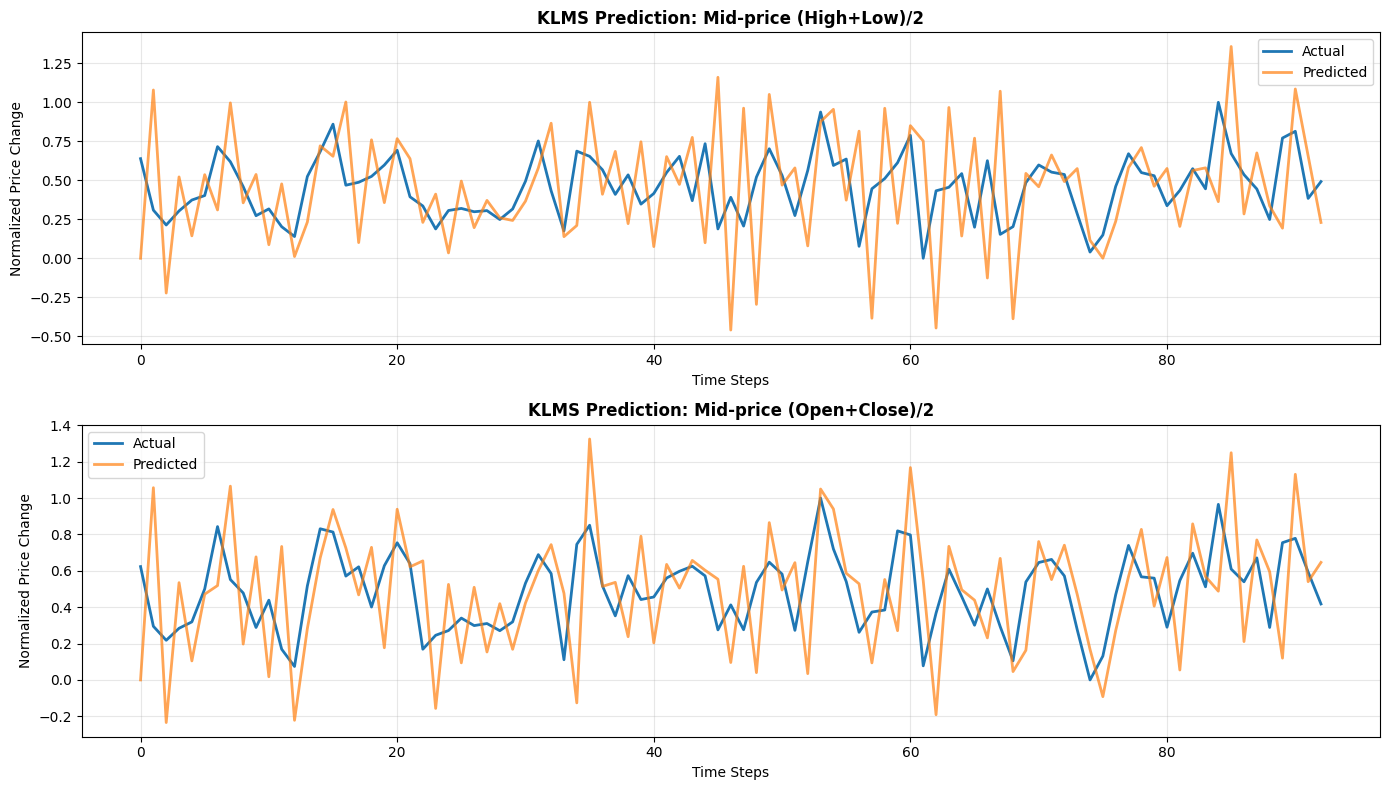

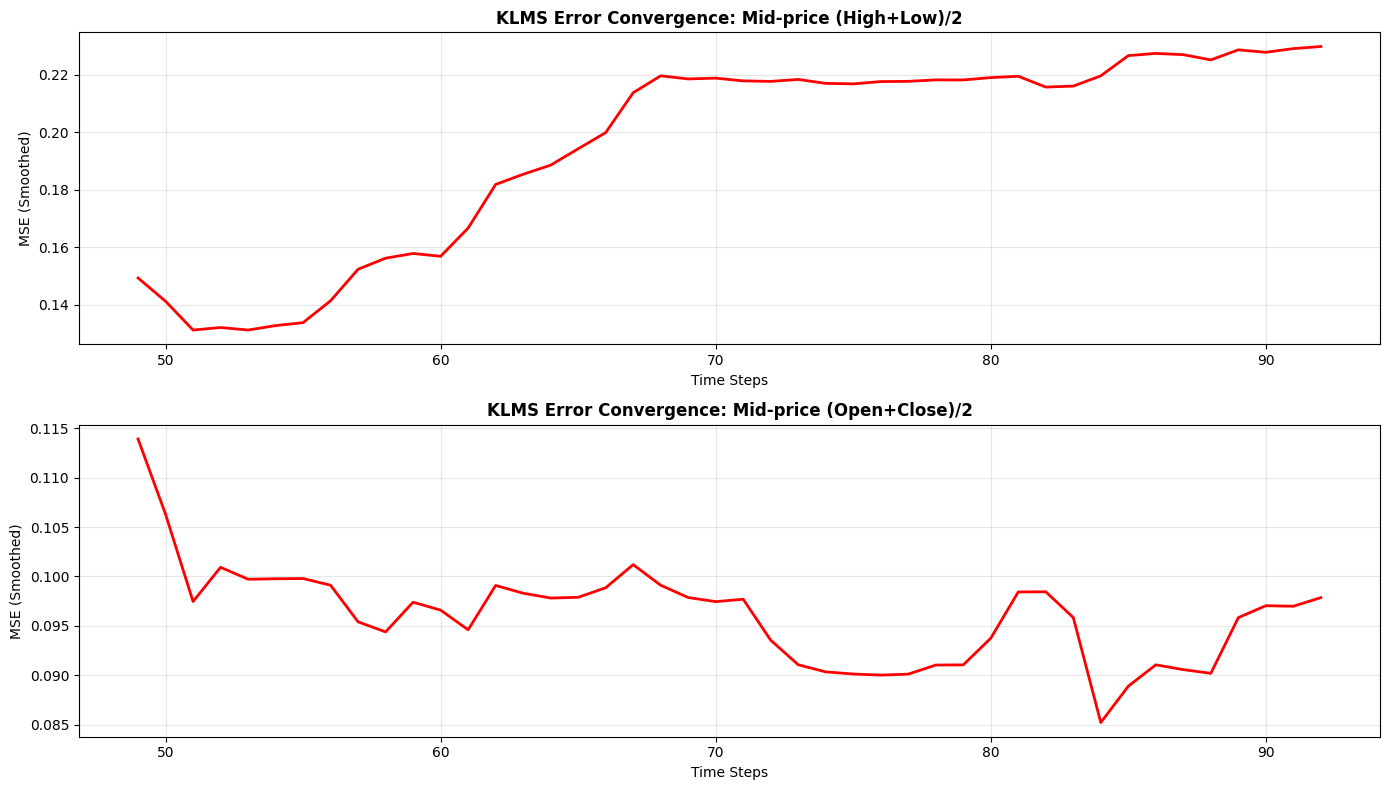

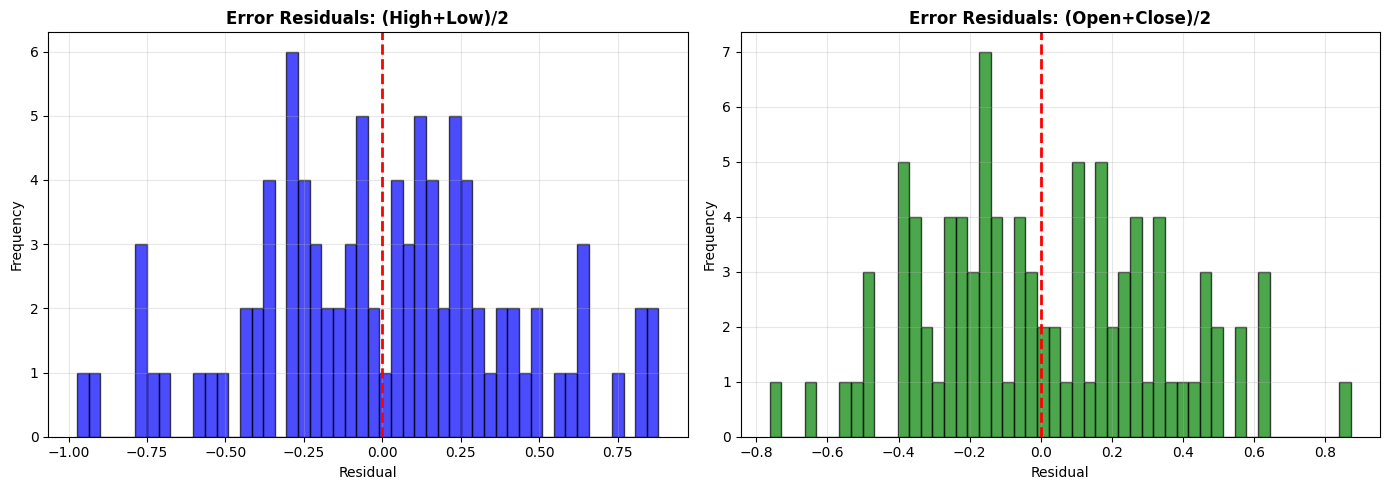

In [35]:
klms_p = {'eta': 1.7, 'sigma': 7.0, 'max_dictionary': 500, 'embedding_dim': 5}
results = execute_benchmark(KLMS, data_titan_hl, data_titan_oc, klms_p, "KLMS")



   KAPA Training - TITAN Stock

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.092541
   MAE: 0.236126
   DS:  0.4348
   Dictionary size: 93

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.072501
   MAE: 0.215448
   DS:  0.5217
   Dictionary size: 93

5. Generating plots...
   ✓ Saved: klms_predictions.png
   ✓ Saved: klms_convergence.png
   ✓ Saved: klms_residuals.png

Training Complete!

SUMMARY OF RESULTS

Mid-price (High+Low)/2:
  MSE: 0.092541
  MAE: 0.236126
  DS:  0.4348 (43.48%)

Mid-price (Open+Close)/2:
  MSE: 0.072501
  MAE: 0.215448
  DS:  0.5217 (52.17%)

Expected results from paper (Table 4, 1-day window):
  KAPA MSE: ~0.0306
  KAPA MAE: ~1.4129
  KAPA DS:  ~0.5378 (53.78%)


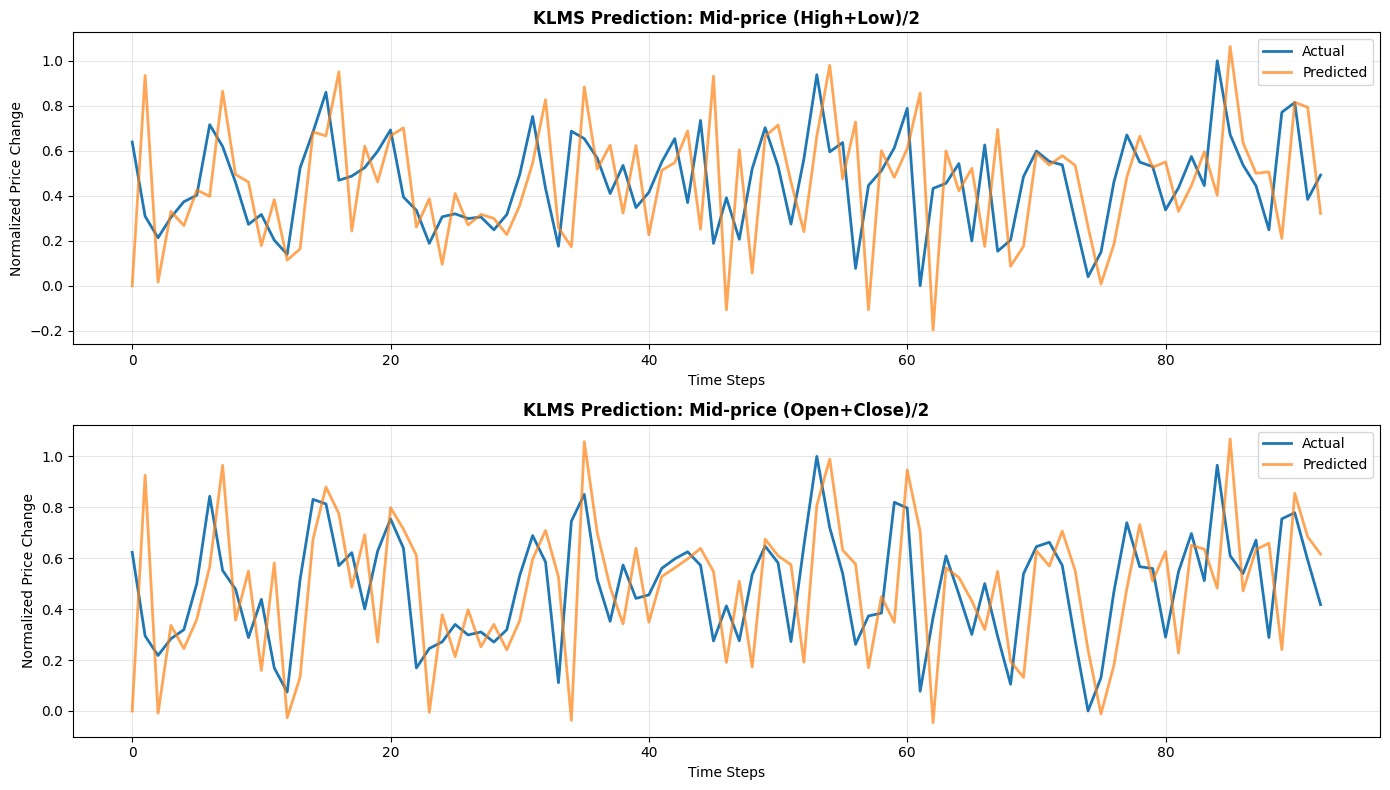

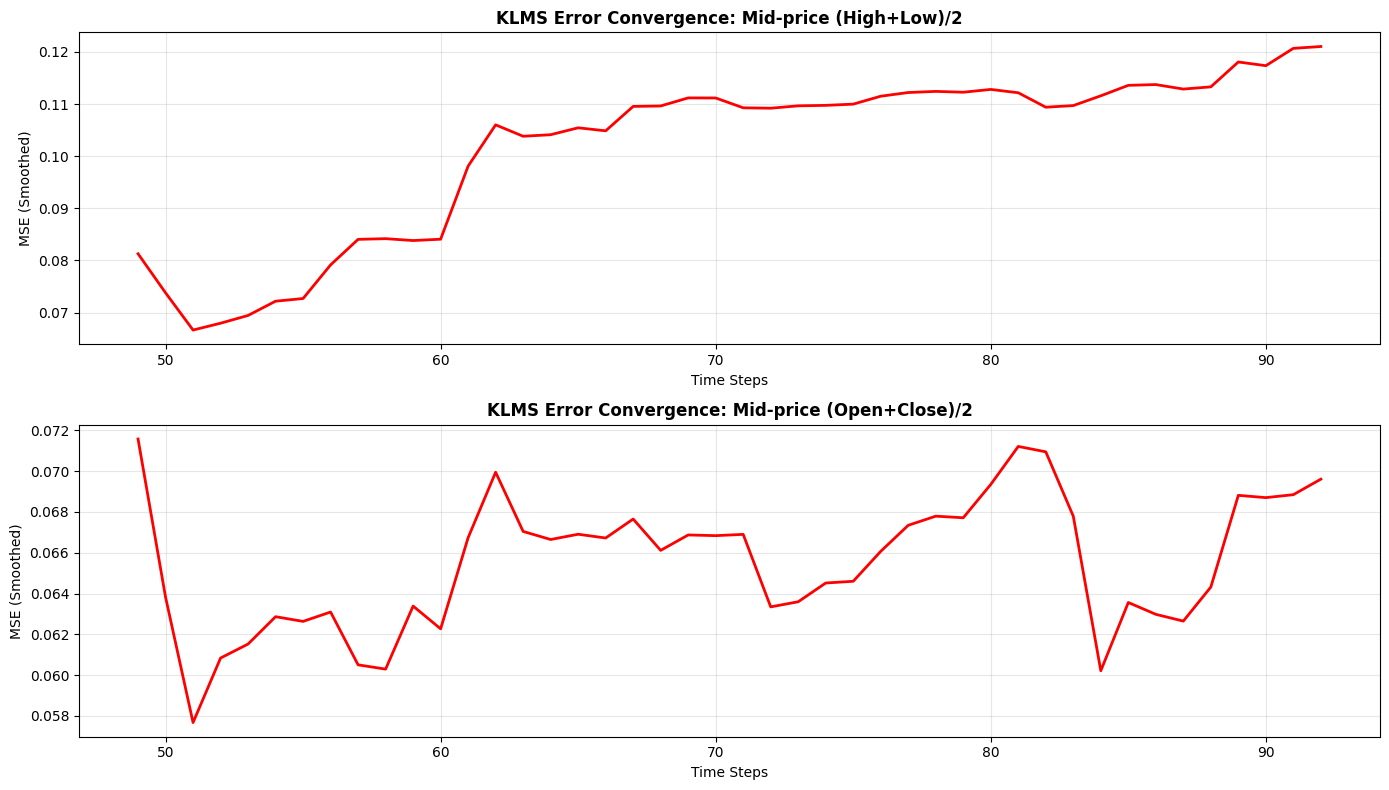

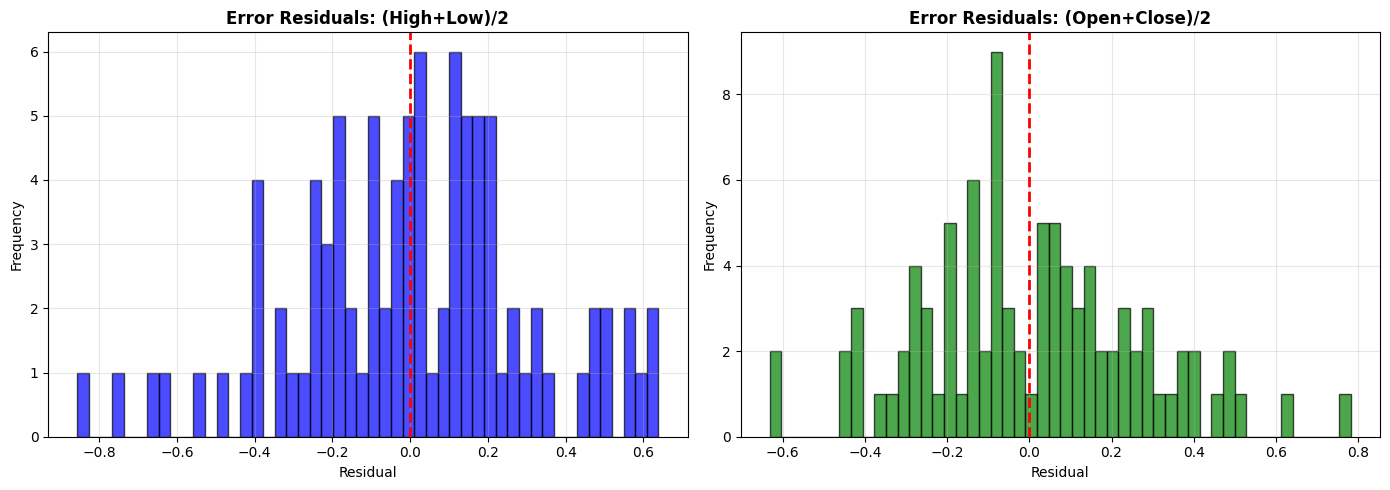

In [37]:
kapa_p = {'eta': 1.5, 'sigma': 5.0, 'max_dictionary': 500, 'embedding_dim': 5}
results = execute_benchmark(KAPA, data_titan_hl, data_titan_oc, kapa_p, "KAPA")

print("\n" + "=" * 70)
print("Expected results from paper (Table 4, 1-day window):")
print("  KAPA MSE: ~0.0306")
print("  KAPA MAE: ~1.4129")
print("  KAPA DS:  ~0.5378 (53.78%)")
print("=" * 70)

## 30 min window size

In [43]:
print("\n" + "="*70)
print("   Downloading 30-minute data for TITAN")
print("="*70)

# Download 30-minute data
ticker = "TITAN.NS"
titan_30m_data = yf.download(ticker, start='2025-11-10', end='2025-12-30', 
                              interval='30m', progress=False)

print(f"   Downloaded {len(titan_30m_data)} data points")
print(f"   Date range: {titan_30m_data.index[0]} to {titan_30m_data.index[-1]}")

# Prepare mid-price data
data_titan_hl_30m = prepare_stock_data(titan_30m_data, mid_price_type='HL')
data_titan_oc_30m = prepare_stock_data(titan_30m_data, mid_price_type='OC')

print(f"   Mid-price (High+Low)/2 prepared: {len(data_titan_hl_30m)} points")
print(f"   Mid-price (Open+Close)/2 prepared: {len(data_titan_oc_30m)} points")



   Downloaded 455 data points
   Date range: 2025-11-10 03:30:00+00:00 to 2025-12-29 09:30:00+00:00
   Mid-price (High+Low)/2 prepared: 454 points
   Mid-price (Open+Close)/2 prepared: 454 points



   KAPA Training - TITAN Stock (30-minute window)

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.033619
   MAE: 0.122794
   DS:  0.4732
   Dictionary size: 449

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.107456
   MAE: 0.273865
   DS:  0.5109
   Dictionary size: 93

5. Generating plots...
   ✓ Saved: klms_predictions.png
   ✓ Saved: klms_convergence.png
   ✓ Saved: klms_residuals.png

Training Complete!

SUMMARY OF RESULTS

Mid-price (High+Low)/2:
  MSE: 0.033619
  MAE: 0.122794
  DS:  0.4732 (47.32%)

Mid-price (Open+Close)/2:
  MSE: 0.107456
  MAE: 0.273865
  DS:  0.5109 (51.09%)


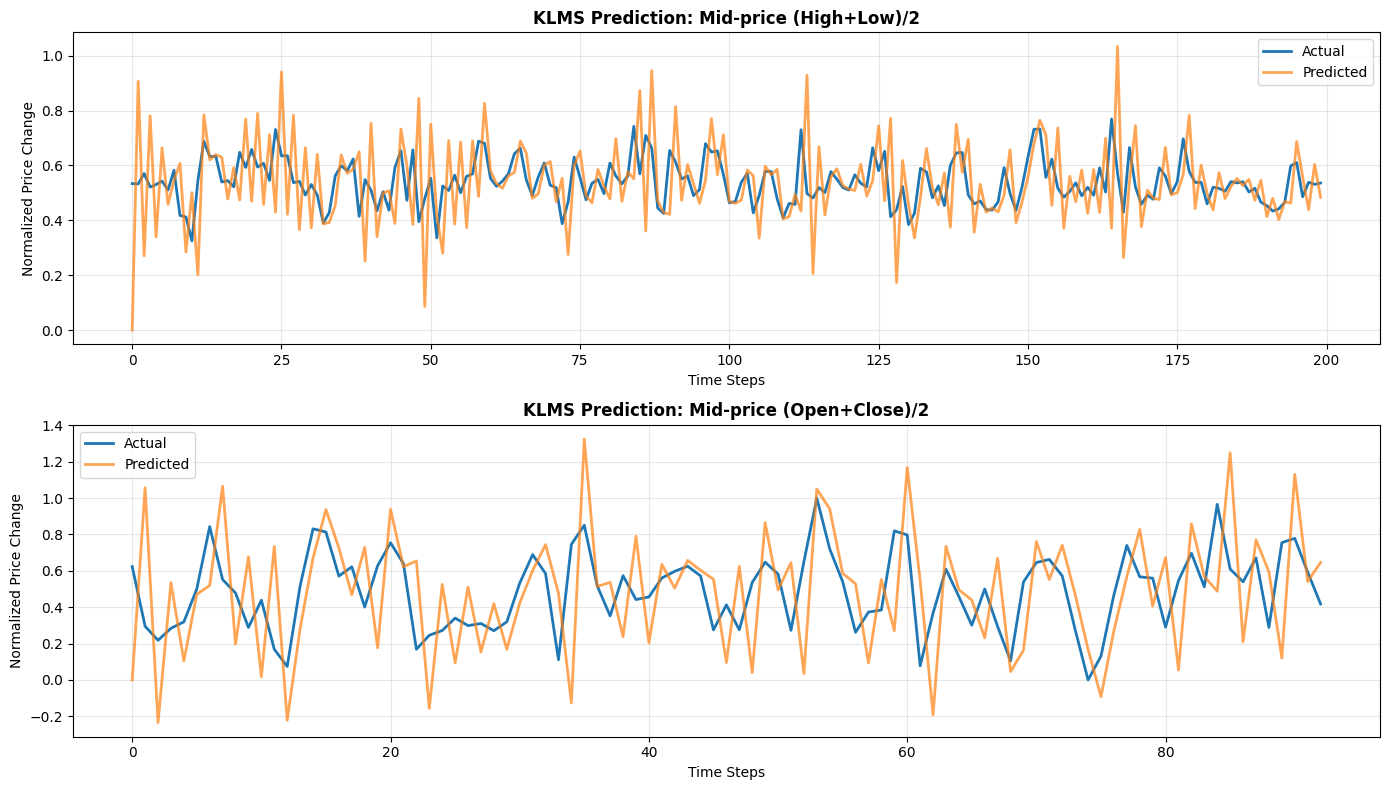

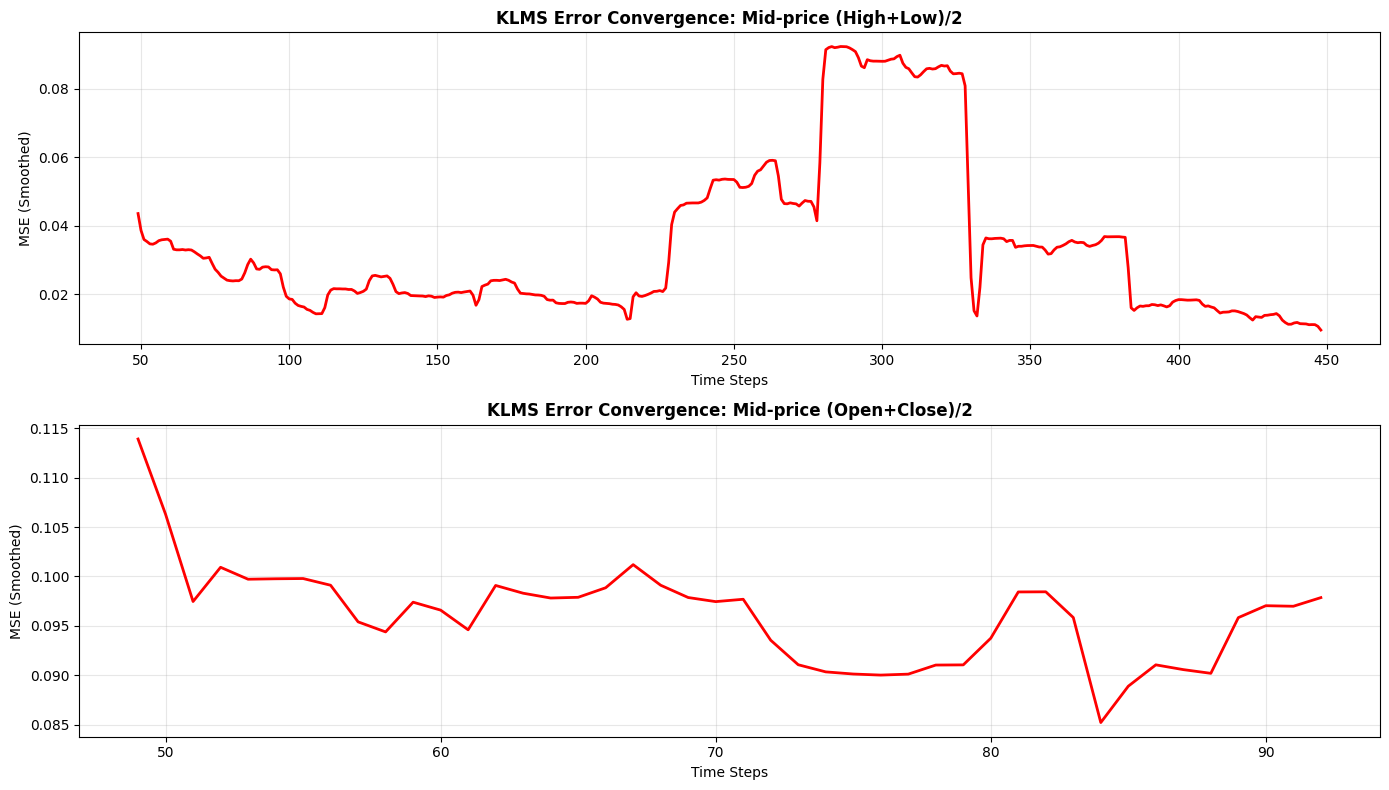

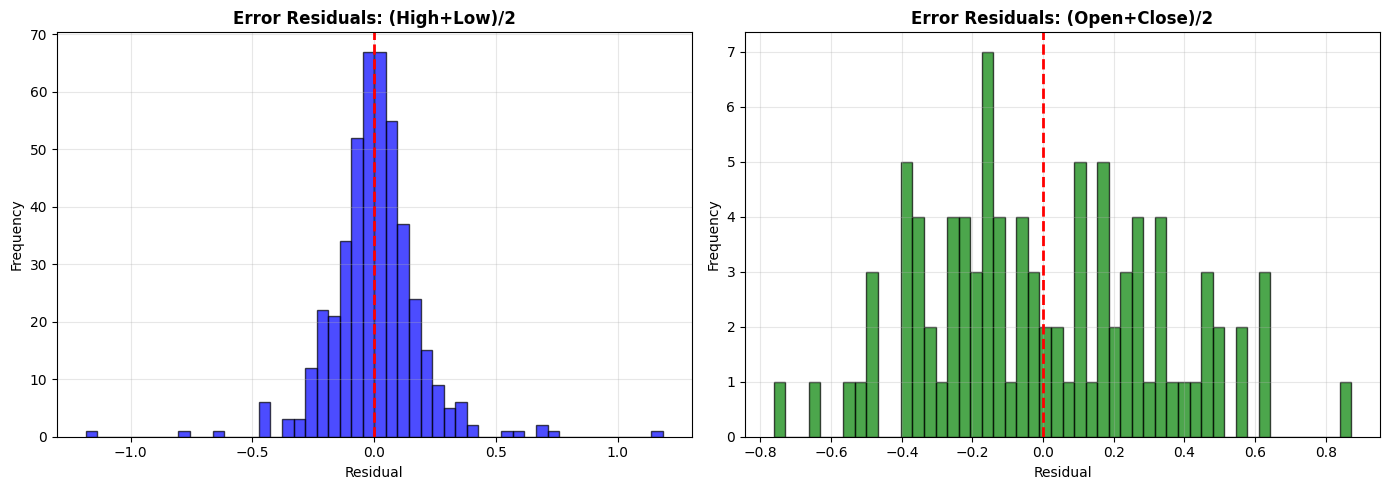

In [47]:
klms_p = {'eta': 1.7, 'sigma': 7.0, 'max_dictionary': 500, 'embedding_dim': 5}
results = execute_benchmark(KLMS, data_titan_hl_30m, data_titan_oc, klms_p, "KAPA", stock_name="TITAN Stock (30-minute window)")



   KAPA Training - TITAN Stock

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.029370
   MAE: 0.114945
   DS:  0.4643
   Dictionary size: 449

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.100903
   MAE: 0.262581
   DS:  0.5109
   Dictionary size: 93

5. Generating plots...
   ✓ Saved: klms_predictions.png
   ✓ Saved: klms_convergence.png
   ✓ Saved: klms_residuals.png

Training Complete!

SUMMARY OF RESULTS

Mid-price (High+Low)/2:
  MSE: 0.029370
  MAE: 0.114945
  DS:  0.4643 (46.43%)

Mid-price (Open+Close)/2:
  MSE: 0.100903
  MAE: 0.262581
  DS:  0.5109 (51.09%)


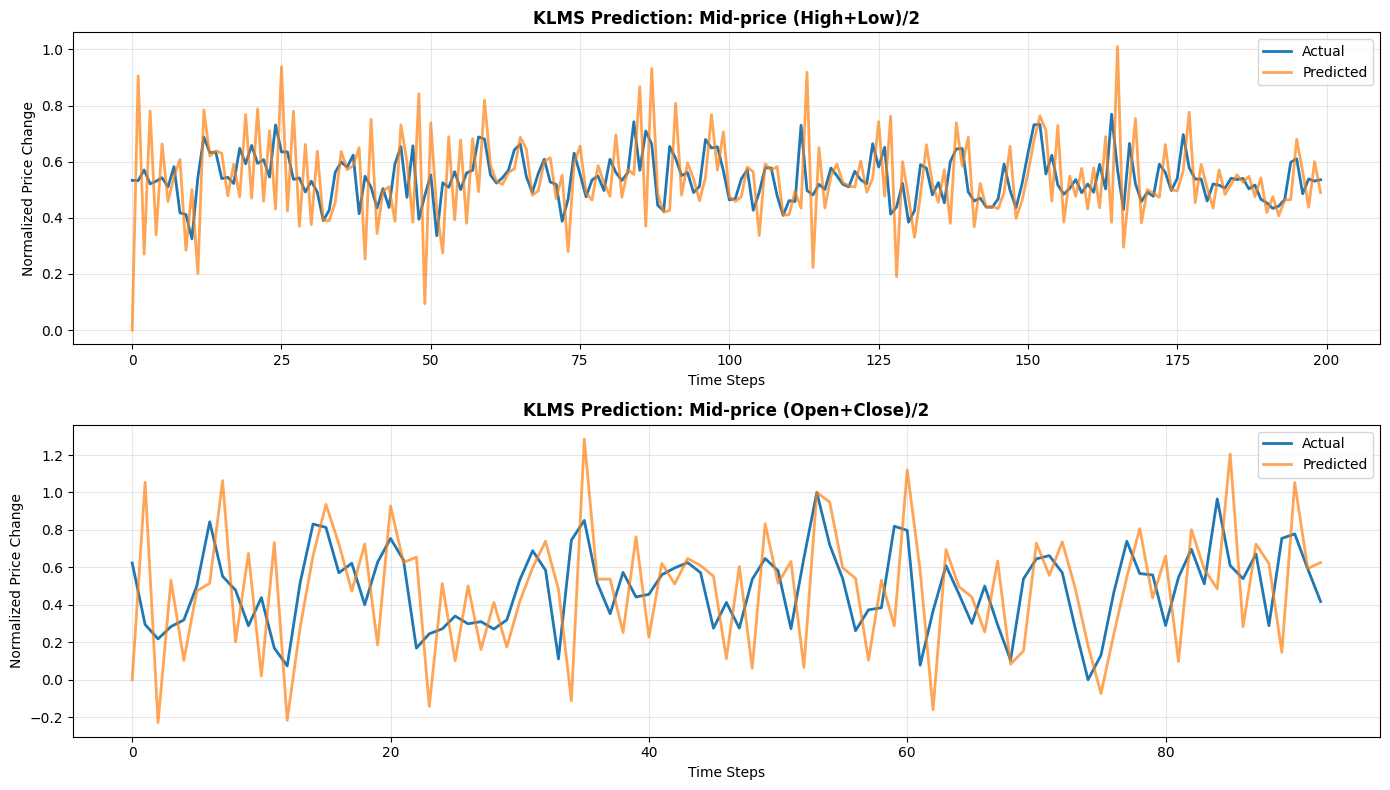

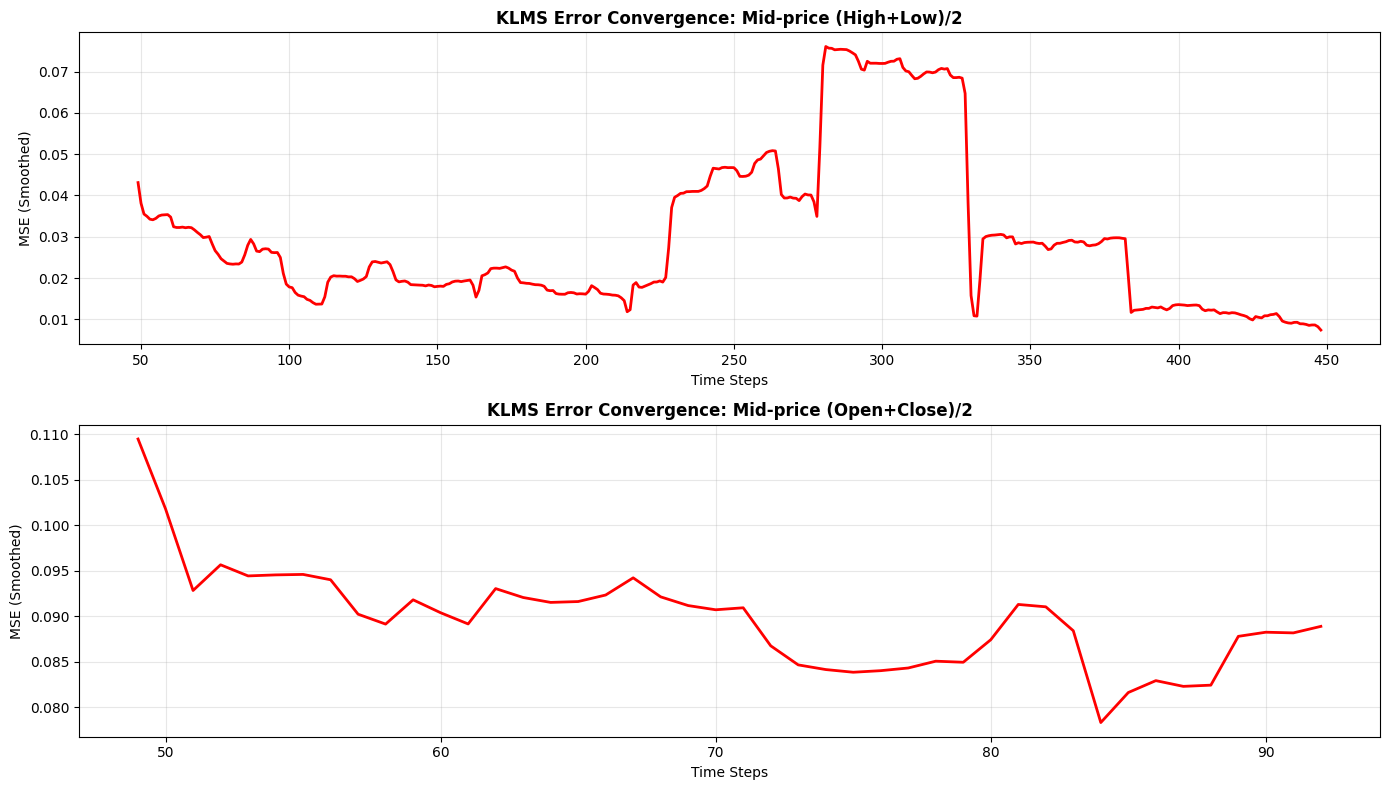

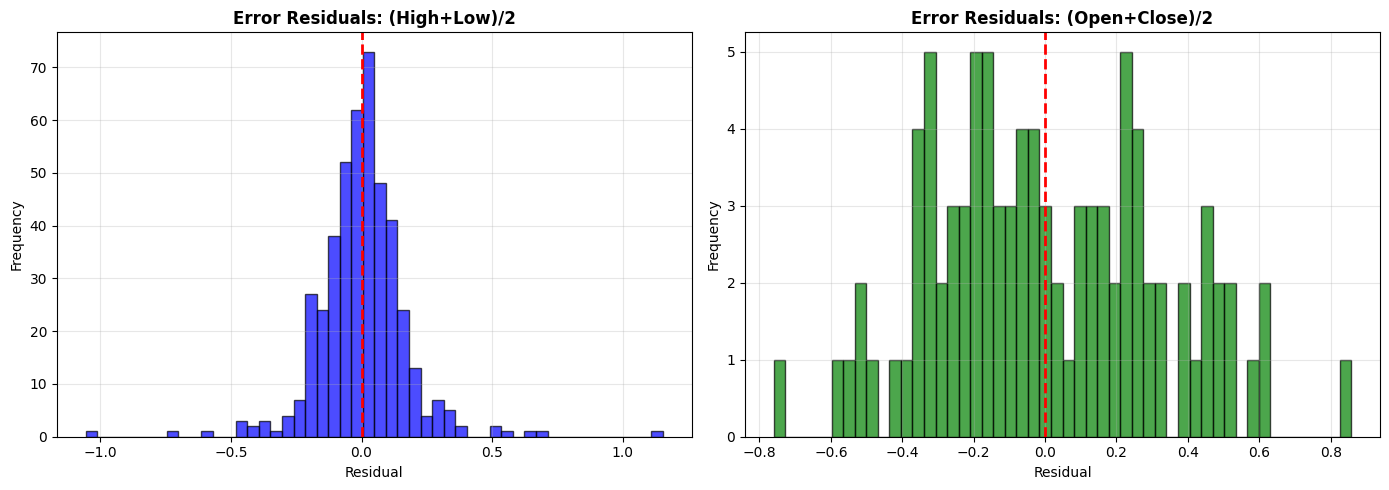

In [46]:
kapa_p = {'eta': 1.7, 'sigma': 7.0, 'max_dictionary': 500, 'embedding_dim': 5}
results = execute_benchmark(KAPA, data_titan_hl_30m, data_titan_oc, kapa_p, "KAPA", stock_name="TITAN Stock (30-minute window)")


# River methods

In [62]:
from river import linear_model
from river import preprocessing
from river import compose
from river import optim
window_label = "30min"
# ============================================================================
# Streaming SGD Regressor (with preprocessing)
# ============================================================================

print("\n" + "="*70)
print(f"   Streaming SGD Regressor - TITAN Stock ({window_label} window)")
print("="*70)

# === Mid-price (High + Low) / 2 ===
print("\n   --- Mid-price: (High + Low) / 2 ---")
model_sgd_hl = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression(
        optimizer=optim.SGD(lr=0.01),
        l2=0.001
    )
)
stream_sgd_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_sgd_hl = evaluate_online(model_sgd_hl, stream_sgd_hl)

print(f"   MSE: {results_sgd_hl['MSE']:.6f}")
print(f"   MAE: {results_sgd_hl['MAE']:.6f}")
print(f"   DS:  {results_sgd_hl['DS']:.4f}")

# === Mid-price (Open + Close) / 2 ===
print("\n   --- Mid-price: (Open + Close) / 2 ---")
model_sgd_oc = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression(
        optimizer=optim.SGD(lr=0.01),
        l2=0.001
    )
)
stream_sgd_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_sgd_oc = evaluate_online(model_sgd_oc, stream_sgd_oc)

print(f"   MSE: {results_sgd_oc['MSE']:.6f}")
print(f"   MAE: {results_sgd_oc['MAE']:.6f}")
print(f"   DS:  {results_sgd_oc['DS']:.4f}")

# ============================================================================
# Passive-Aggressive Regressor
# ============================================================================

print("\n" + "="*70)
print(f"   Passive-Aggressive Regressor - TITAN Stock ({window_label} window)")
print("="*70)

# === Mid-price (High + Low) / 2 ===
print("\n   --- Mid-price: (High + Low) / 2 ---")
model_pa_hl = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.PARegressor(
        C=0.01,
        mode=2  # PA-II
    )
)
stream_pa_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_pa_hl = evaluate_online(model_pa_hl, stream_pa_hl)

print(f"   MSE: {results_pa_hl['MSE']:.6f}")
print(f"   MAE: {results_pa_hl['MAE']:.6f}")
print(f"   DS:  {results_pa_hl['DS']:.4f}")

# === Mid-price (Open + Close) / 2 ===
print("\n   --- Mid-price: (Open + Close) / 2 ---")
model_pa_oc = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.PARegressor(
        C=0.01,
        mode=2
    )
)
stream_pa_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_pa_oc = evaluate_online(model_pa_oc, stream_pa_oc)

print(f"   MSE: {results_pa_oc['MSE']:.6f}")
print(f"   MAE: {results_pa_oc['MAE']:.6f}")
print(f"   DS:  {results_pa_oc['DS']:.4f}")

# ============================================================================
# Adaptive Model Rules (AMRules) - Best for time series!
# ============================================================================

from river import rules

print("\n" + "="*70)
print(f"   AMRules Regressor - TITAN Stock ({window_label} window)")
print("="*70)

# === Mid-price (High + Low) / 2 ===
print("\n   --- Mid-price: (High + Low) / 2 ---")
model_amr_hl = rules.AMRules(
    n_min=30,
    delta=1e-7,
    tau=0.05,
    pred_type='adaptive'
)
stream_amr_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_amr_hl = evaluate_online(model_amr_hl, stream_amr_hl)

print(f"   MSE: {results_amr_hl['MSE']:.6f}")
print(f"   MAE: {results_amr_hl['MAE']:.6f}")
print(f"   DS:  {results_amr_hl['DS']:.4f}")

# === Mid-price (Open + Close) / 2 ===
print("\n   --- Mid-price: (Open + Close) / 2 ---")
model_amr_oc = rules.AMRules(
    n_min=30,
    delta=1e-7,
    tau=0.05,
    pred_type='adaptive'
)
stream_amr_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_amr_oc = evaluate_online(model_amr_oc, stream_amr_oc)

print(f"   MSE: {results_amr_oc['MSE']:.6f}")
print(f"   MAE: {results_amr_oc['MAE']:.6f}")
print(f"   DS:  {results_amr_oc['DS']:.4f}")

# ============================================================================
# KNN Regressor (with adaptive window)
# ============================================================================

from river import neighbors

print("\n" + "="*70)
print(f"   KNN Regressor - TITAN Stock ({window_label} window)")
print("="*70)

# === Mid-price (High + Low) / 2 ===
print("\n   --- Mid-price: (High + Low) / 2 ---")
model_knn_hl = neighbors.KNNRegressor(
    n_neighbors=5,
    aggregation_method='mean'
)
stream_knn_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_knn_hl = evaluate_online(model_knn_hl, stream_knn_hl)

print(f"   MSE: {results_knn_hl['MSE']:.6f}")
print(f"   MAE: {results_knn_hl['MAE']:.6f}")
print(f"   DS:  {results_knn_hl['DS']:.4f}")

# === Mid-price (Open + Close) / 2 ===
print("\n   --- Mid-price: (Open + Close) / 2 ---")
model_knn_oc = neighbors.KNNRegressor(
    n_neighbors=5,
    aggregation_method='mean'
)
stream_knn_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_knn_oc = evaluate_online(model_knn_oc, stream_knn_oc)

print(f"   MSE: {results_knn_oc['MSE']:.6f}")
print(f"   MAE: {results_knn_oc['MAE']:.6f}")
print(f"   DS:  {results_knn_oc['DS']:.4f}")

# ============================================================================
# Update CSV with all River models
# ============================================================================

print("\n" + "="*70)
print("   Updating Results CSV with River Models")
print("="*70)


# Add all River model results
river_results = pd.DataFrame({
    'Algorithm': ['SGD', 'SGD', 'PARegressor', 'PARegressor', 
                  'AMRules', 'AMRules', 'KNN', 'KNN'],
    'Mid_Price_Type': ['(High+Low)/2', '(Open+Close)/2'] * 4,
    'Time_Window': [window_label] * 8,
    'MSE': [results_sgd_hl['MSE'], results_sgd_oc['MSE'],
            results_pa_hl['MSE'], results_pa_oc['MSE'],
            results_amr_hl['MSE'], results_amr_oc['MSE'],
            results_knn_hl['MSE'], results_knn_oc['MSE']],
    'MAE': [results_sgd_hl['MAE'], results_sgd_oc['MAE'],
            results_pa_hl['MAE'], results_pa_oc['MAE'],
            results_amr_hl['MAE'], results_amr_oc['MAE'],
            results_knn_hl['MAE'], results_knn_oc['MAE']],
    'DS': [results_sgd_hl['DS'], results_sgd_oc['DS'],
           results_pa_hl['DS'], results_pa_oc['DS'],
           results_amr_hl['DS'], results_amr_oc['DS'],
           results_knn_hl['DS'], results_knn_oc['DS']],
    'DS_%': [results_sgd_hl['DS']*100, results_sgd_oc['DS']*100,
             results_pa_hl['DS']*100, results_pa_oc['DS']*100,
             results_amr_hl['DS']*100, results_amr_oc['DS']*100,
             results_knn_hl['DS']*100, results_knn_oc['DS']*100],
    'Dictionary_Size': ['-', '-', '-', '-', '-', '-', '-', '-'],
    'Data_Points': [len(data_titan_hl_30m)] * 8,
    'Timestamp': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * 8
})

# Save detailed predictions for each model
models_to_save = [
    ('sgd', results_sgd_hl, results_sgd_oc),
    ('pa', results_pa_hl, results_pa_oc),
    ('amr', results_amr_hl, results_amr_oc),
    ('knn', results_knn_hl, results_knn_oc)
]

for model_name, results_hl, results_oc in models_to_save:
    # High + Low
    pd.DataFrame({
        'actual': results_hl['actuals'],
        'predicted': results_hl['predictions'],
        'error': results_hl['errors'],
        'residual': np.array(results_hl['actuals']) - np.array(results_hl['predictions'])
    }).to_csv(f'{model_name}_{window_label}_hl_detailed.csv', index=False)
    

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print(f"RIVER MODELS SUMMARY - {window_label.upper()} WINDOW")
print("=" * 70)

models_summary = [
    ('SGD', results_sgd_hl, results_sgd_oc),
    ('Passive-Aggressive', results_pa_hl, results_pa_oc),
    ('AMRules', results_amr_hl, results_amr_oc),
    ('KNN', results_knn_hl, results_knn_oc)
]

for model_name, results_hl, results_oc in models_summary:
    print(f"\n--- {model_name} ---")
    print(f"\nMid-price (High+Low)/2:")
    print(f"  MSE: {results_hl['MSE']:.6f}")
    print(f"  MAE: {results_hl['MAE']:.6f}")
    print(f"  DS:  {results_hl['DS']:.4f} ({results_hl['DS']*100:.2f}%)")
    
    print(f"\nMid-price (Open+Close)/2:")
    print(f"  MSE: {results_oc['MSE']:.6f}")
    print(f"  MAE: {results_oc['MAE']:.6f}")
    print(f"  DS:  {results_oc['DS']:.4f} ({results_oc['DS']*100:.2f}%)")

print("\n" + "=" * 70)
print("River models training complete!")
print("=" * 70)


   Streaming SGD Regressor - TITAN Stock (30min window)

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.027500
   MAE: 0.107716
   DS:  0.4554

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.028300
   MAE: 0.102710
   DS:  0.5223

   Passive-Aggressive Regressor - TITAN Stock (30min window)

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.103780
   MAE: 0.265784
   DS:  0.4643

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.149131
   MAE: 0.337278
   DS:  0.5268

   AMRules Regressor - TITAN Stock (30min window)

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.008946
   MAE: 0.067108
   DS:  0.2812

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.007650
   MAE: 0.059726
   DS:  0.3460

   KNN Regressor - TITAN Stock (30min window)

   --- Mid-price: (High + Low) / 2 ---
   MSE: 0.010192
   MAE: 0.073962
   DS:  0.4196

   --- Mid-price: (Open + Close) / 2 ---
   MSE: 0.007814
   MAE: 0.060155
   DS:  0.5022

   Updating Results CSV with River Models

RIVER MODELS SUMMAR

In [61]:
eta_klms = 1.7
sigma_klms = 7.0
embedding_dim = 5
max_dictionary = 500

model_klms_hl = KLMS(eta=eta_klms, sigma=sigma_klms, max_dictionary=max_dictionary)
stream_klms_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_klms_hl = evaluate_online(model_klms_hl, stream_klms_hl)


model_klms_oc = KLMS(eta=eta_klms, sigma=sigma_klms, max_dictionary=max_dictionary)
stream_klms_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_klms_oc = evaluate_online(model_klms_oc, stream_klms_oc)


eta_kapa = 1.5
sigma_kapa = 5.0
K = 20
epsilon = 1e-4

model_kapa_hl = KAPA(eta=eta_kapa, sigma=sigma_kapa, K=K, epsilon=epsilon, 
                      max_dictionary=max_dictionary)
stream_kapa_hl = create_stream(data_titan_hl_30m, embedding_dim=embedding_dim)
results_kapa_hl = evaluate_online(model_kapa_hl, stream_kapa_hl)

model_kapa_oc = KAPA(eta=eta_kapa, sigma=sigma_kapa, K=K, epsilon=epsilon, 
                      max_dictionary=max_dictionary)
stream_kapa_oc = create_stream(data_titan_oc_30m, embedding_dim=embedding_dim)
results_kapa_oc = evaluate_online(model_kapa_oc, stream_kapa_oc)

   ✓ Saved: sgd_predictions_30min.png
   ✓ Saved: sgd_convergence_30min.png
   ✓ Saved: sgd_residuals_30min.png
   ✓ Saved: pa_predictions_30min.png
   ✓ Saved: pa_convergence_30min.png
   ✓ Saved: pa_residuals_30min.png
   ✓ Saved: amr_predictions_30min.png
   ✓ Saved: amr_convergence_30min.png
   ✓ Saved: amr_residuals_30min.png
   ✓ Saved: knn_predictions_30min.png
   ✓ Saved: knn_convergence_30min.png
   ✓ Saved: knn_residuals_30min.png

8. Generating comprehensive comparison plots (30min window)...
   ✓ Saved: comparison_mse_all_30min.png
   ✓ Saved: comparison_mae_all_30min.png
   ✓ Saved: comparison_ds_all_30min.png
   ✓ Saved: comparison_convergence_all_30min.png

All plots generated successfully!


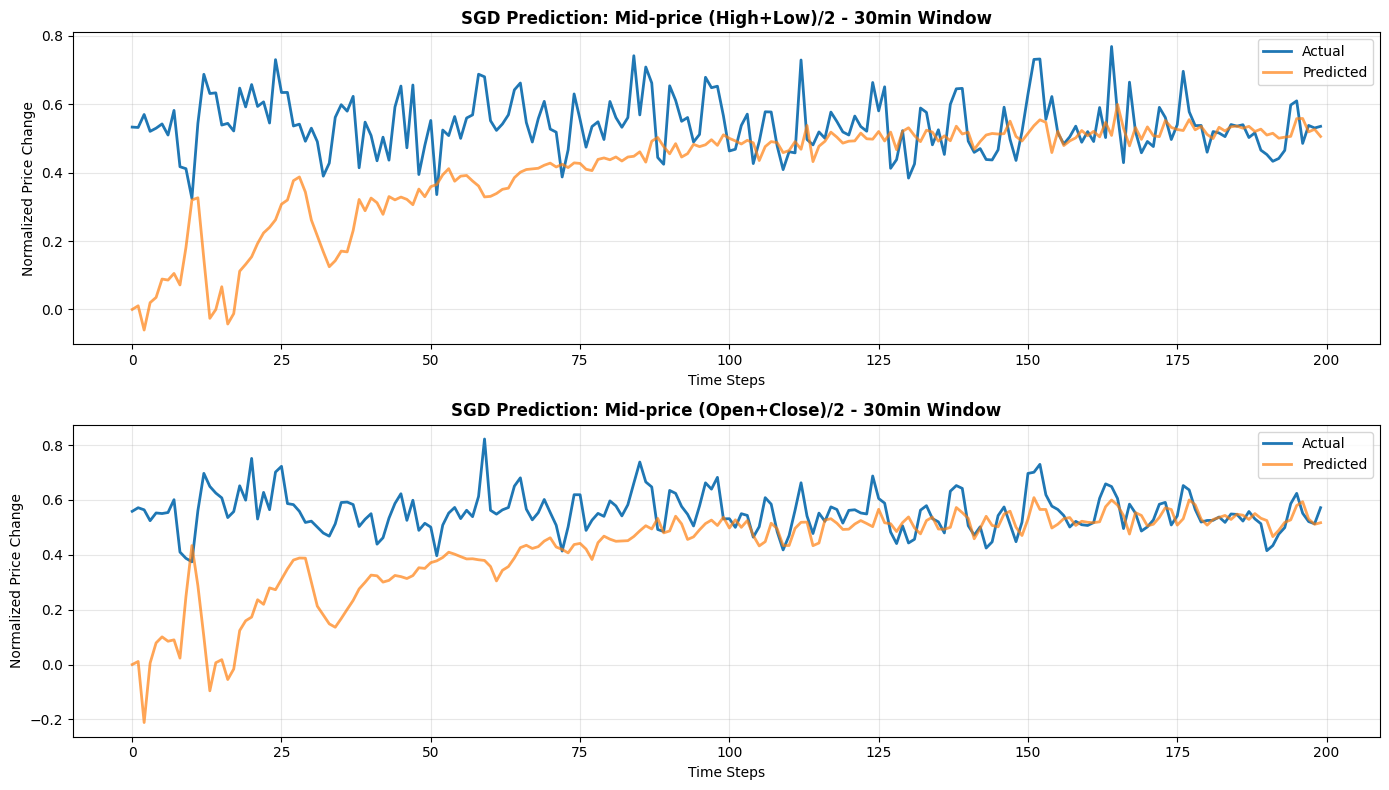

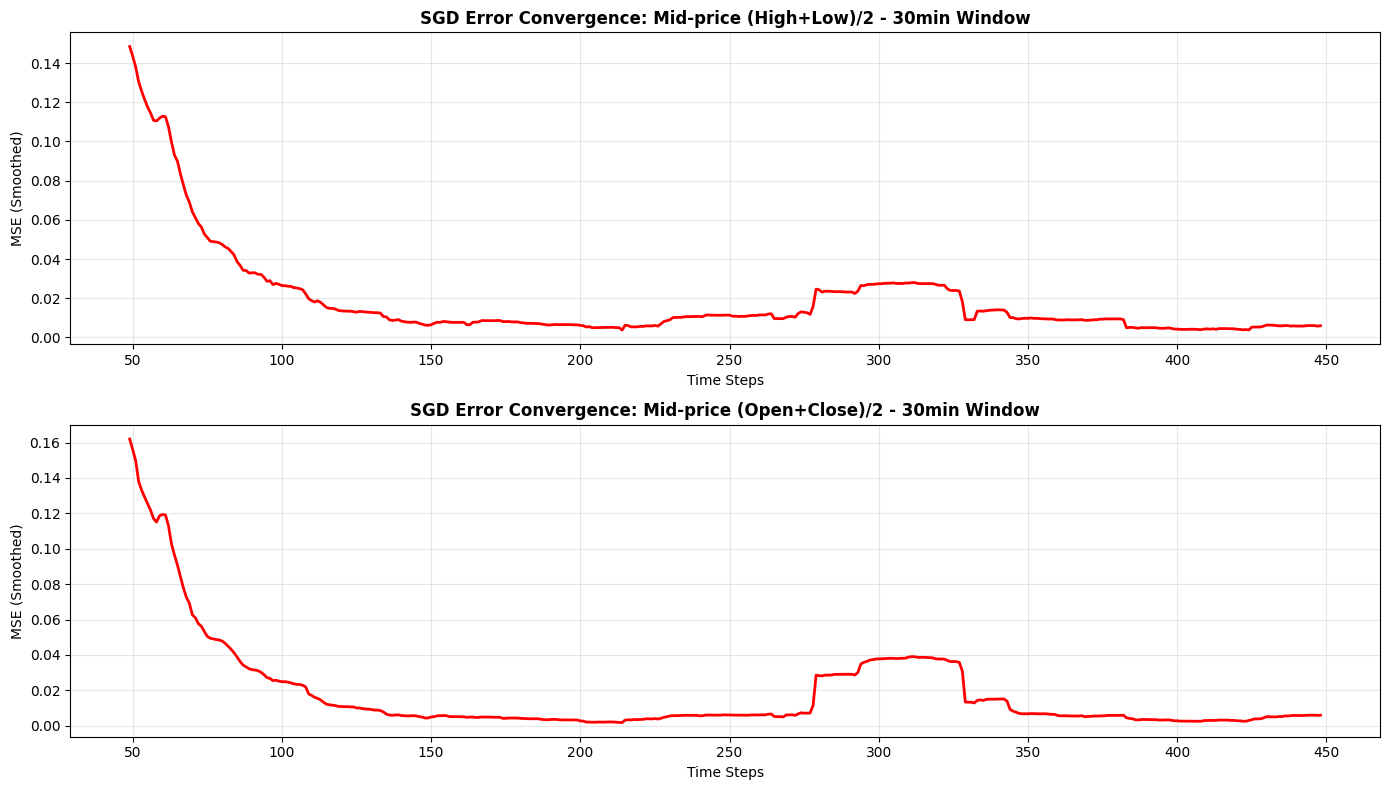

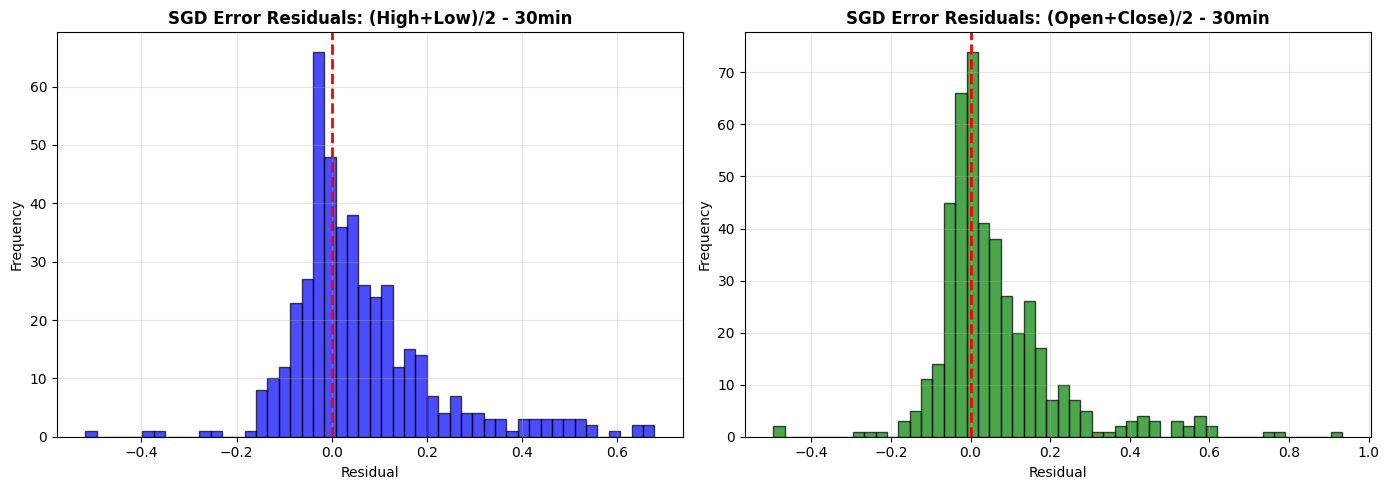

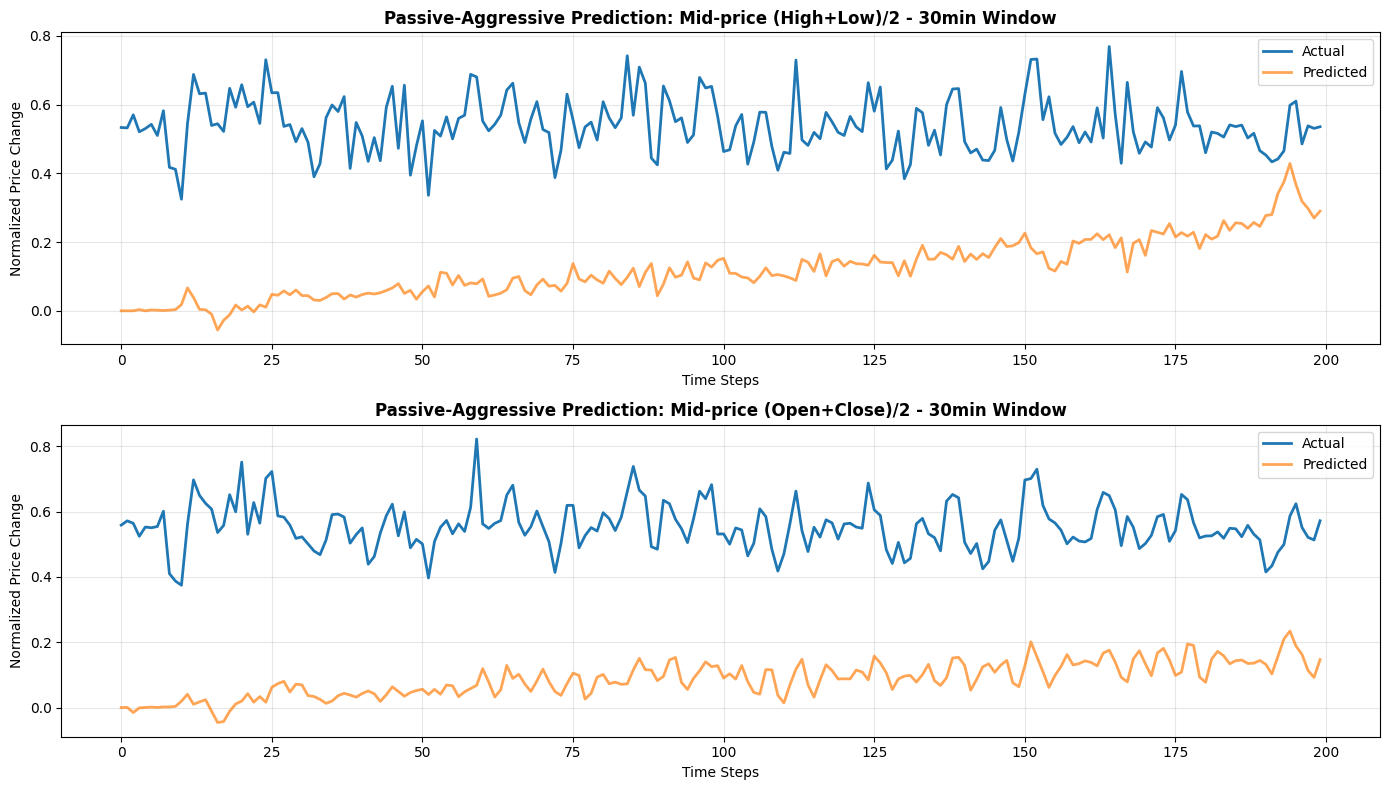

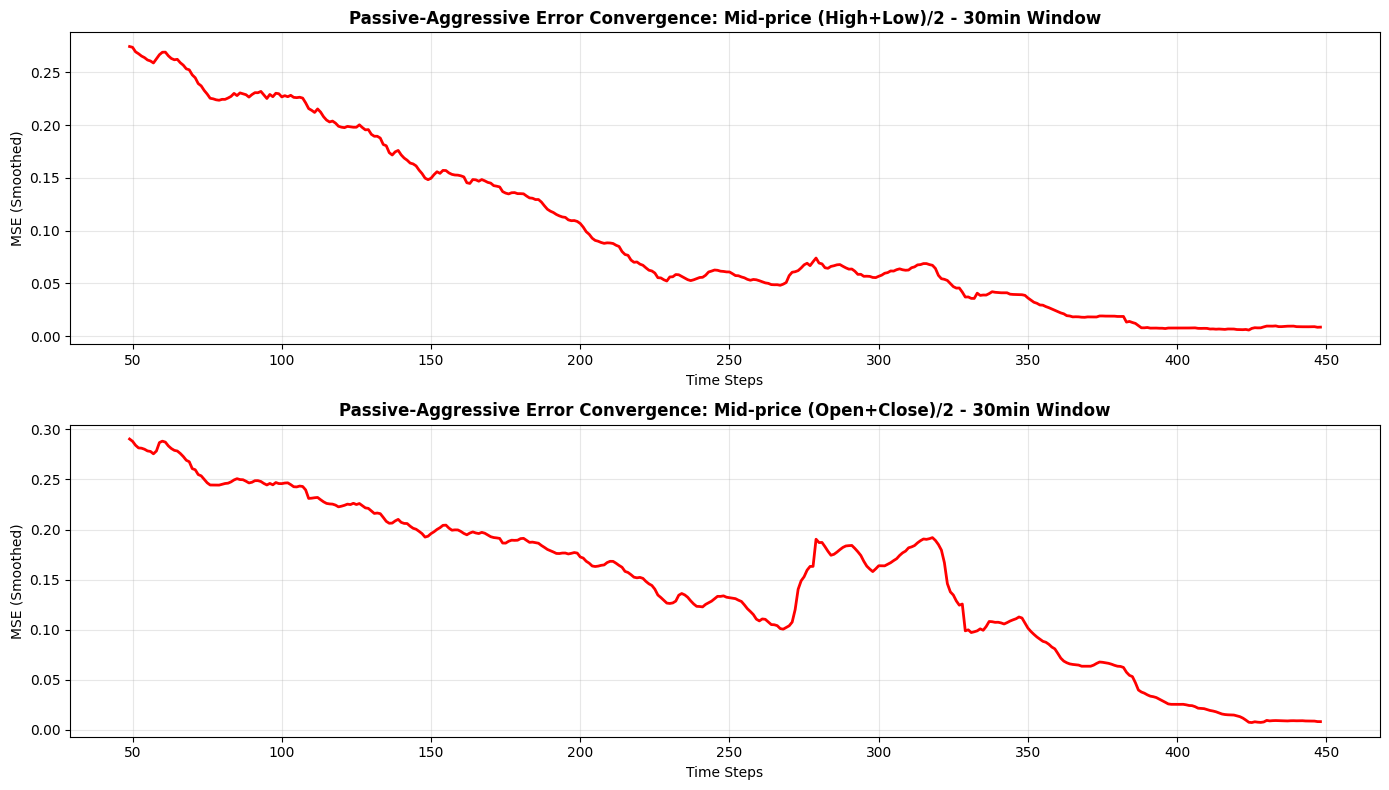

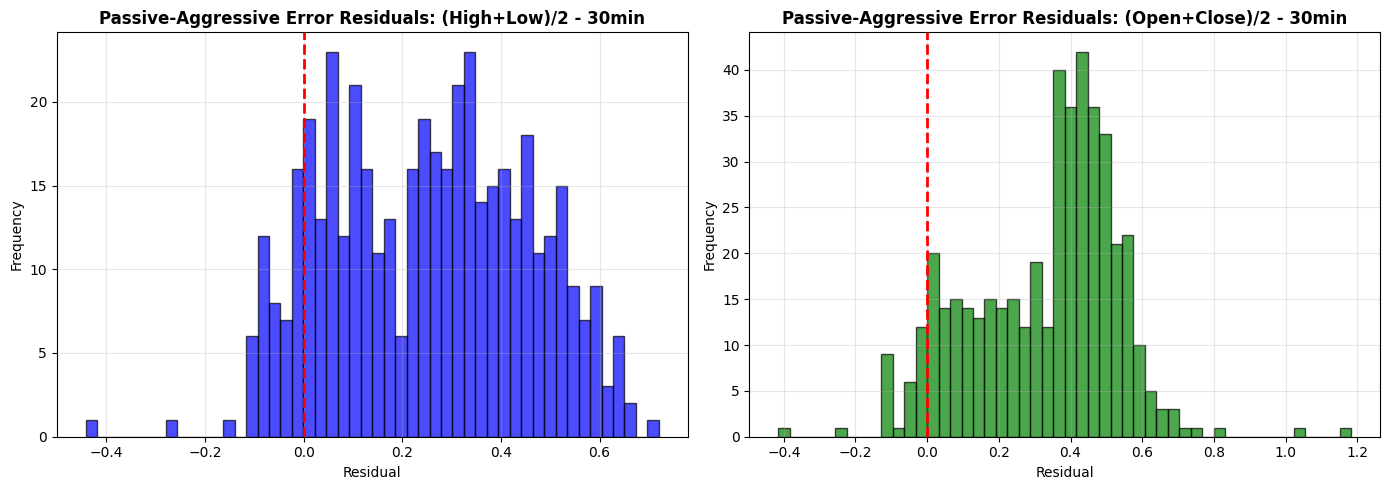

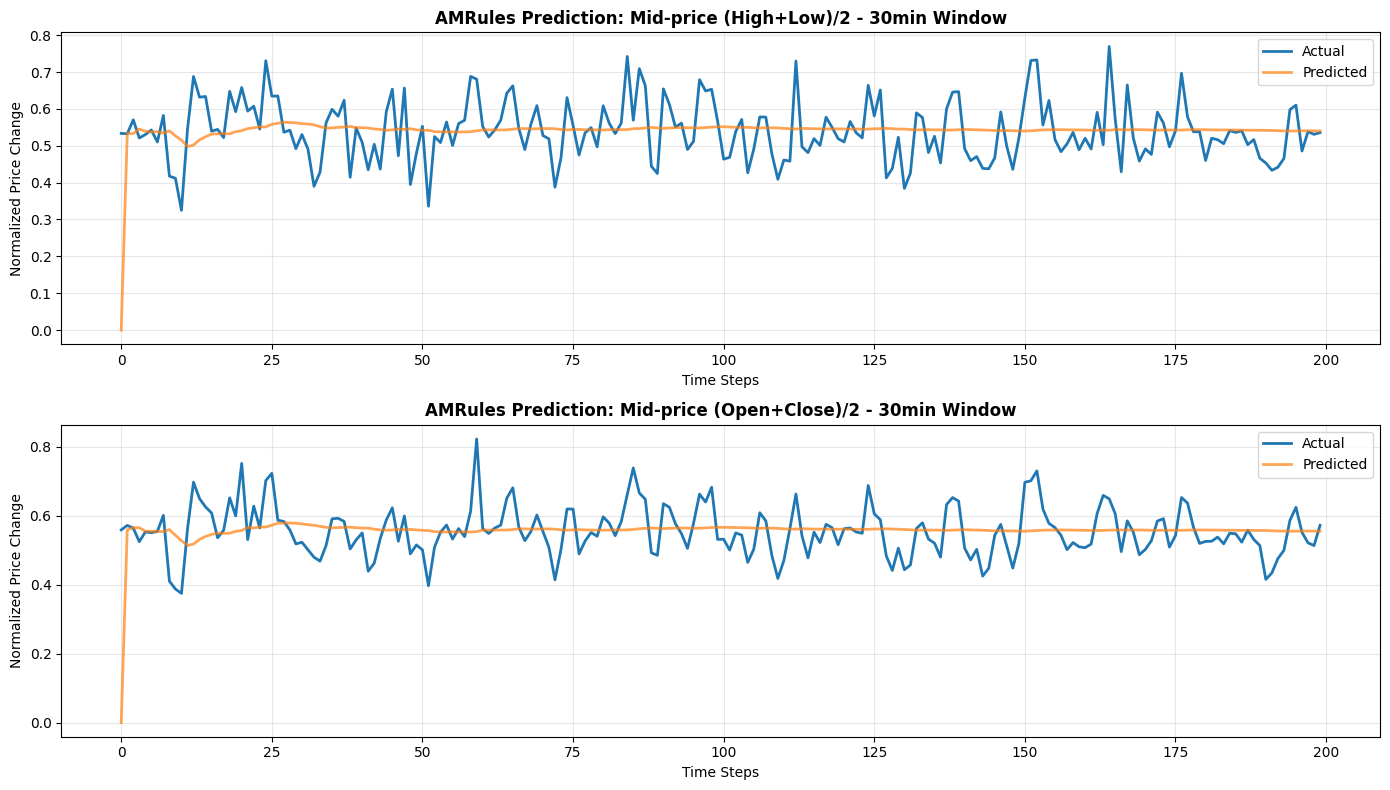

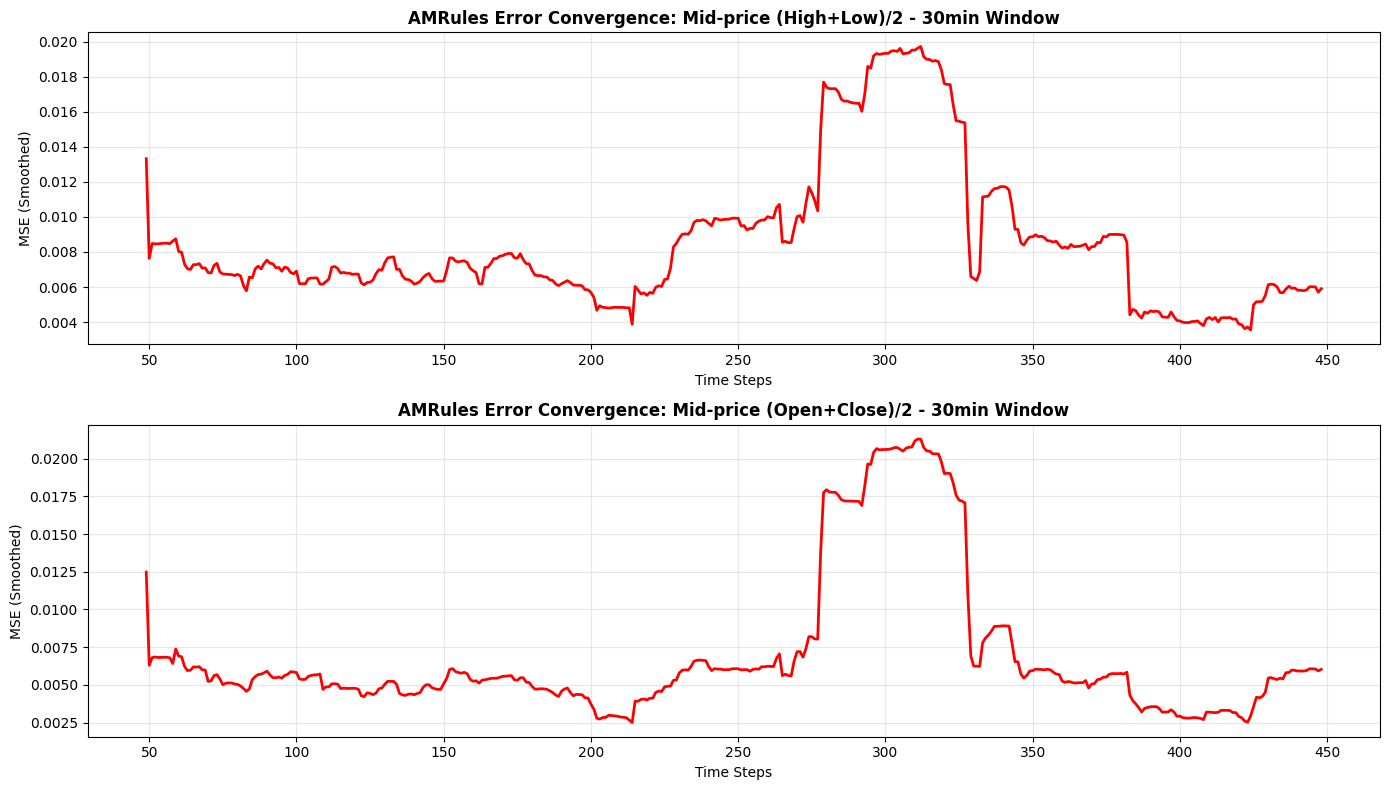

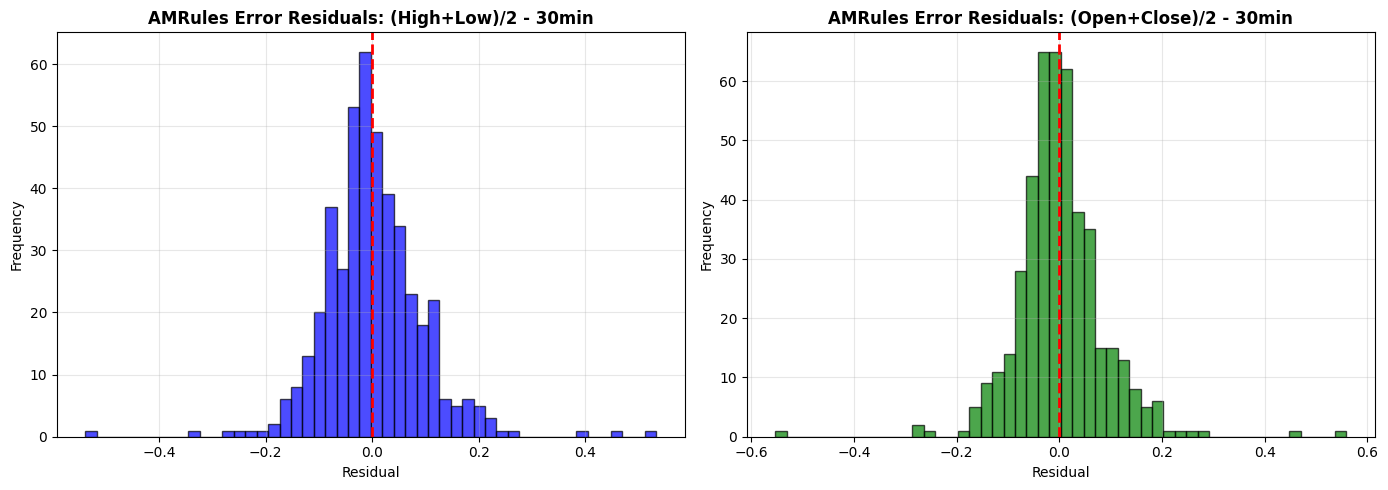

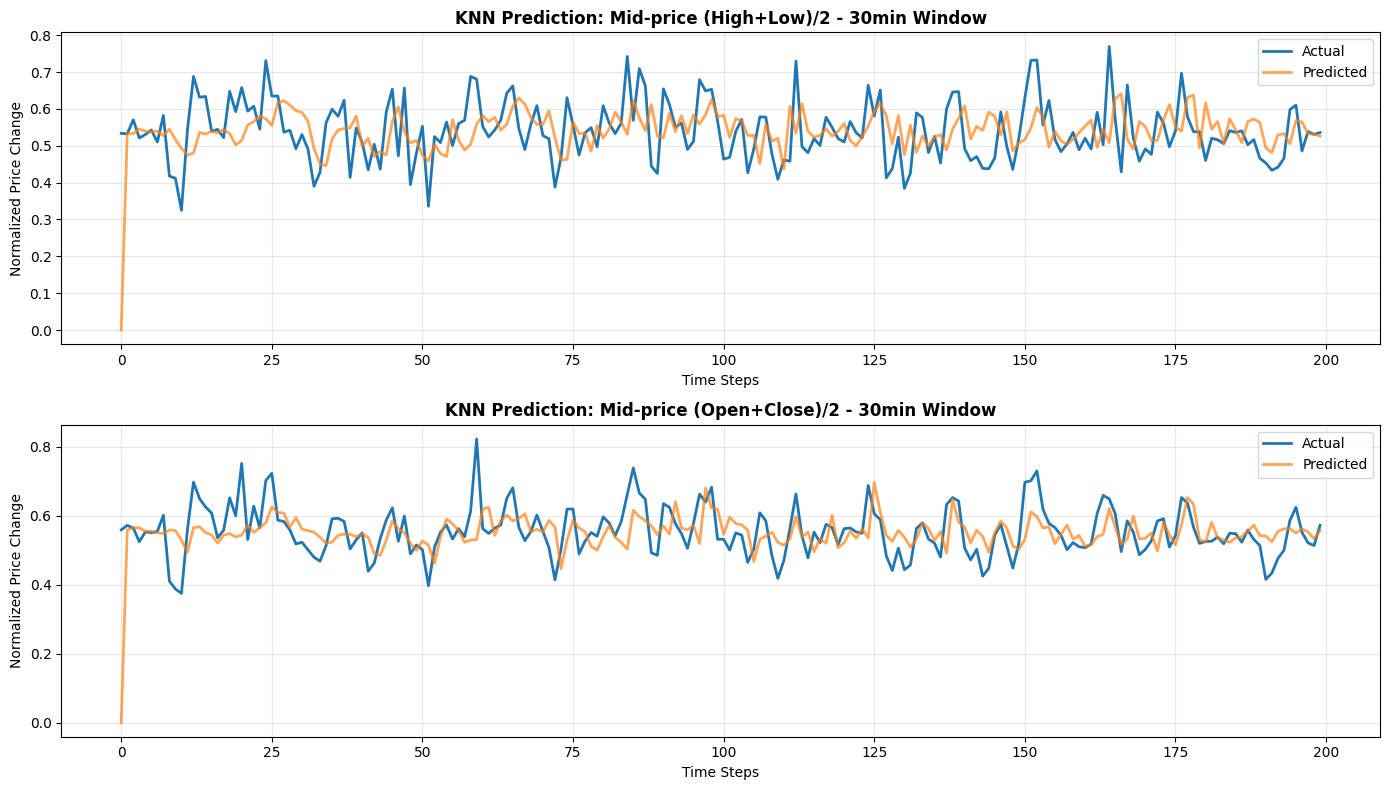

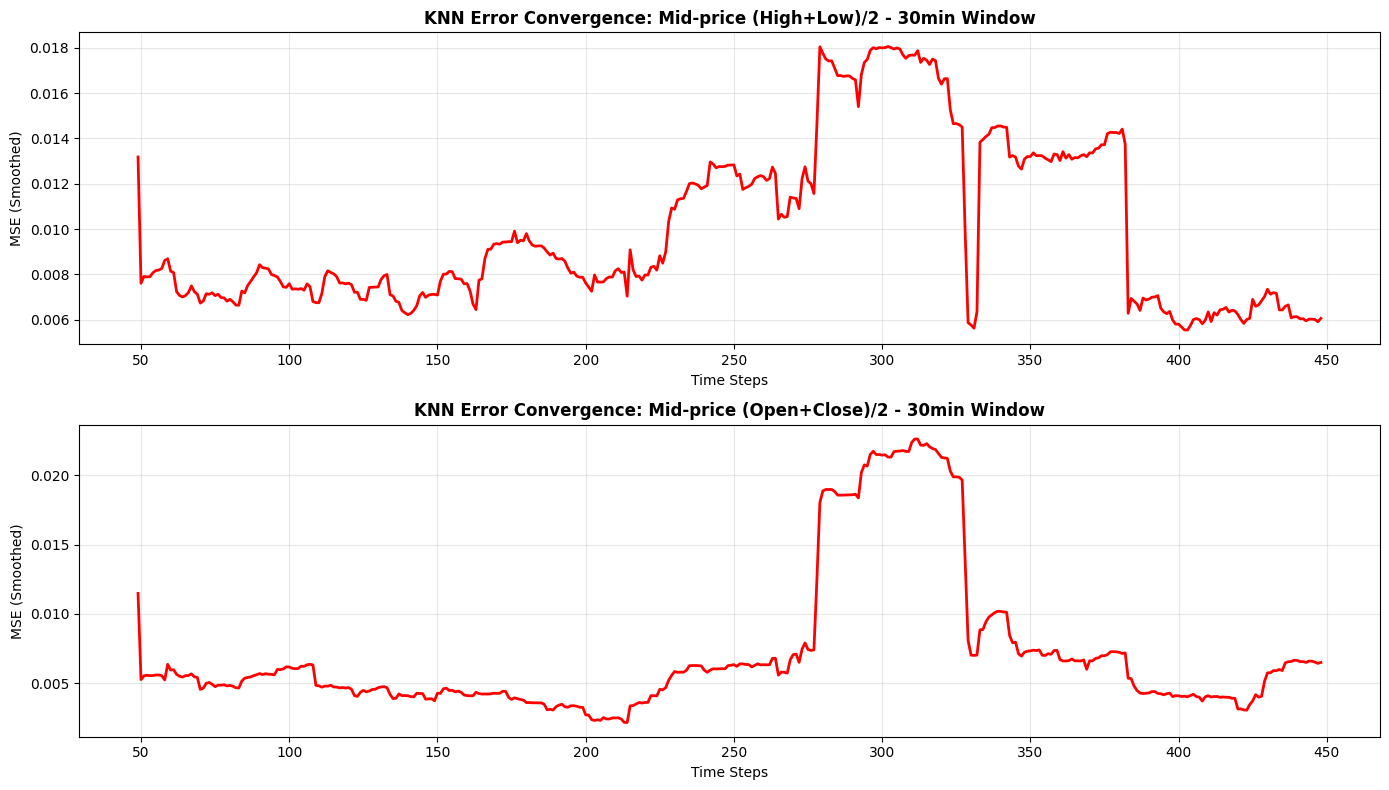

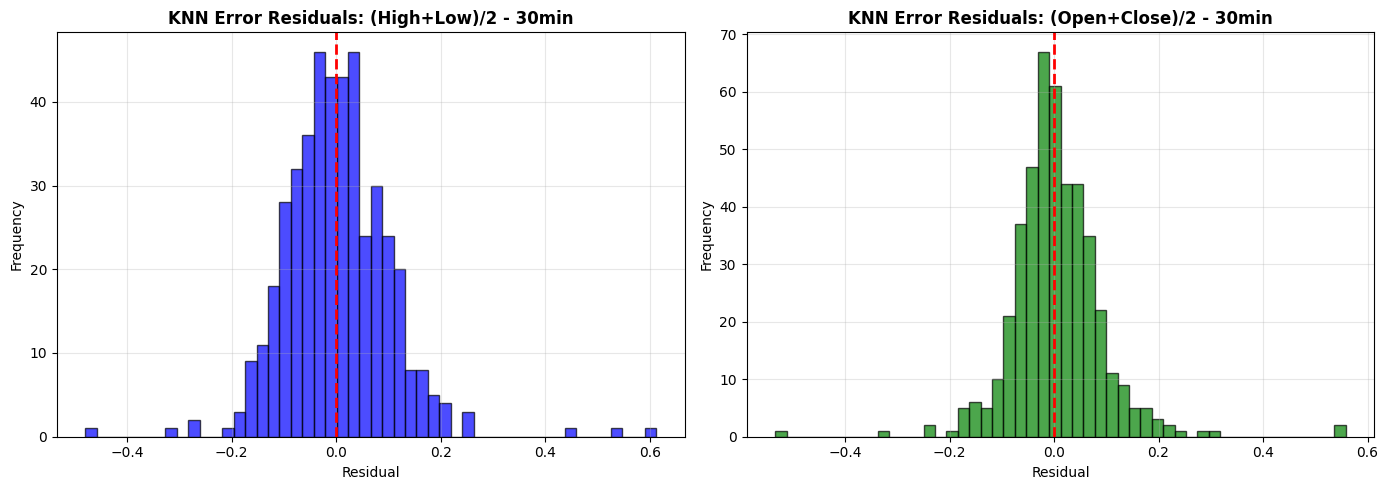

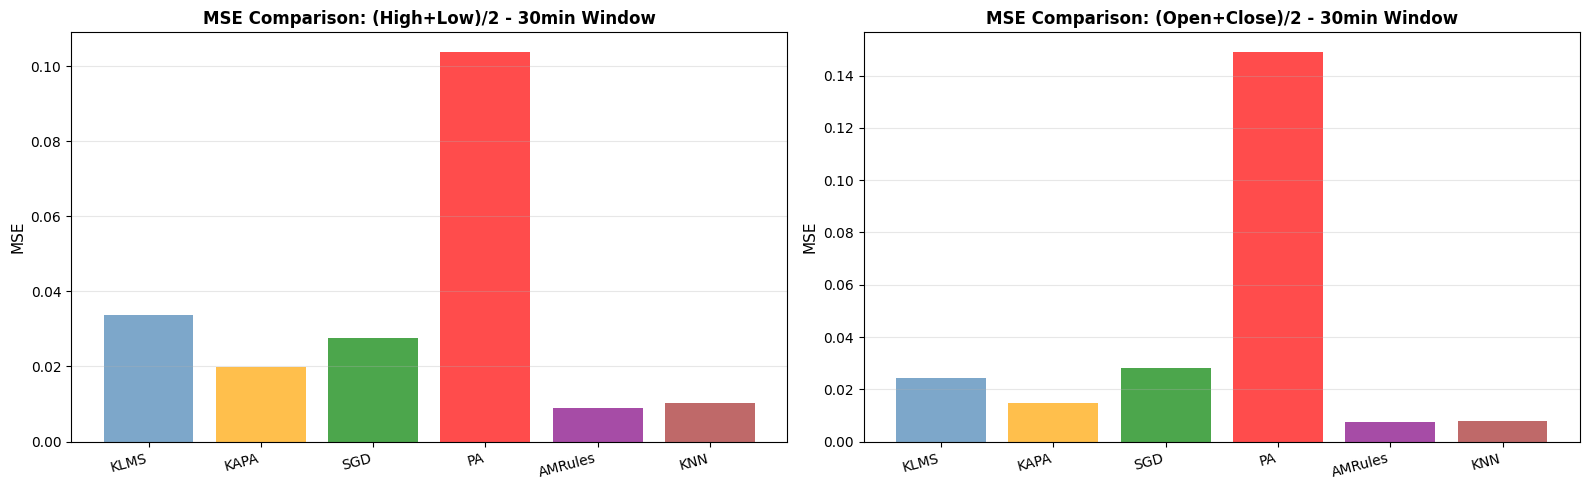

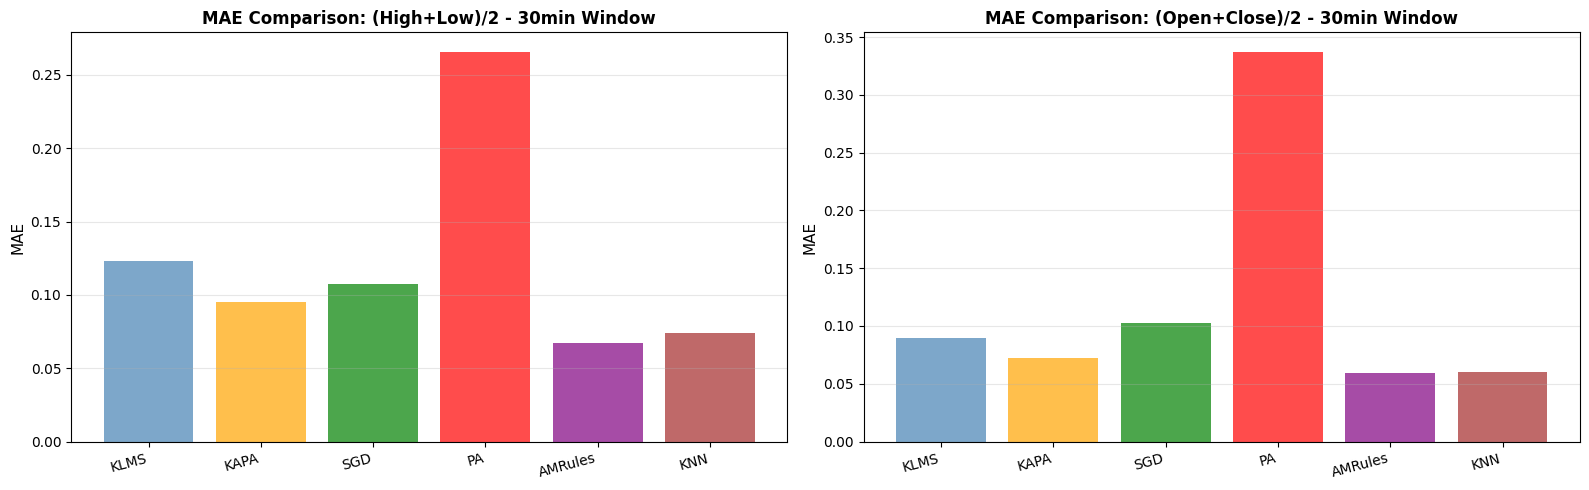

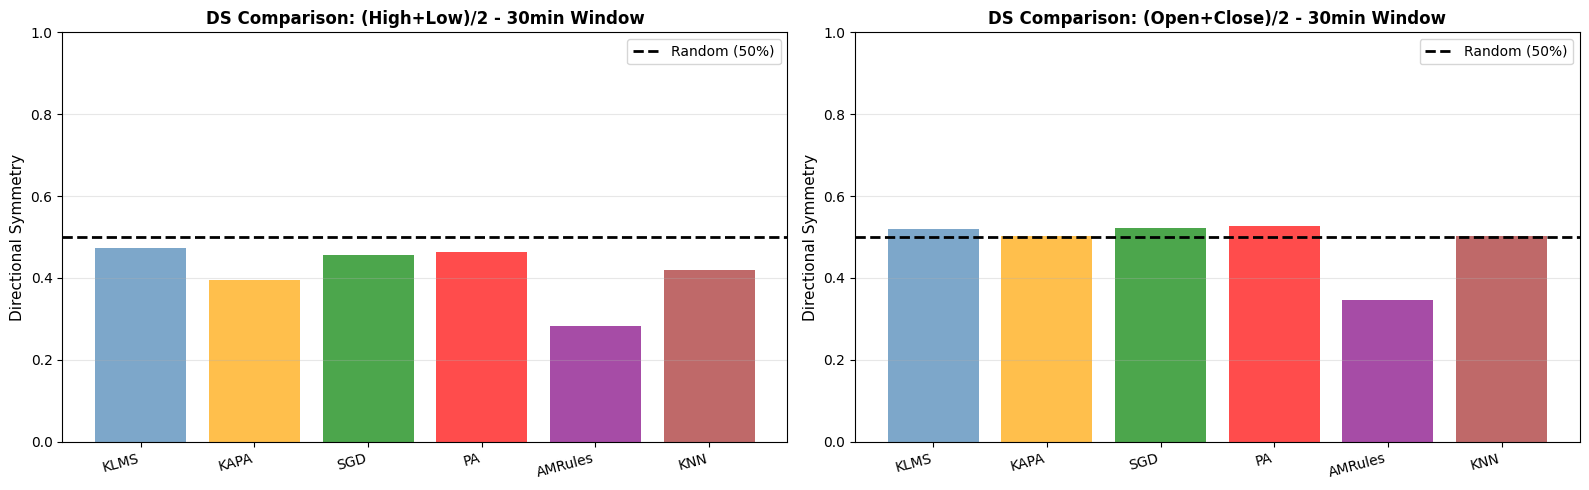

In [66]:
# ============================================================================
# Visualizations for River Models
# ============================================================================

# print(f"\n7. Generating River models plots ({window_label} window)...")

n_plot = 200
window_size = 50

# Get smoothed errors for all models
errors_smoothed_sgd_hl = pd.Series(results_sgd_hl['errors']).rolling(window=window_size).mean()
errors_smoothed_sgd_oc = pd.Series(results_sgd_oc['errors']).rolling(window=window_size).mean()
errors_smoothed_pa_hl = pd.Series(results_pa_hl['errors']).rolling(window=window_size).mean()
errors_smoothed_pa_oc = pd.Series(results_pa_oc['errors']).rolling(window=window_size).mean()
errors_smoothed_amr_hl = pd.Series(results_amr_hl['errors']).rolling(window=window_size).mean()
errors_smoothed_amr_oc = pd.Series(results_amr_oc['errors']).rolling(window=window_size).mean()
errors_smoothed_knn_hl = pd.Series(results_knn_hl['errors']).rolling(window=window_size).mean()
errors_smoothed_knn_oc = pd.Series(results_knn_oc['errors']).rolling(window=window_size).mean()

# ============================================================================
# SGD Plots
# ============================================================================

# Plot 1: SGD Predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(results_sgd_hl['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0].plot(results_sgd_hl['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'SGD Prediction: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Normalized Price Change')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_sgd_oc['actuals'][:n_plot], label='Actual', linewidth=2)
axes[1].plot(results_sgd_oc['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title(f'SGD Prediction: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Normalized Price Change')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'sgd_predictions_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: sgd_predictions_{window_label}.png")

# Plot 2: SGD Error Convergence
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(errors_smoothed_sgd_hl, color='red', linewidth=2)
axes[0].set_title(f'SGD Error Convergence: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('MSE (Smoothed)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(errors_smoothed_sgd_oc, color='red', linewidth=2)
axes[1].set_title(f'SGD Error Convergence: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('MSE (Smoothed)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'sgd_convergence_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: sgd_convergence_{window_label}.png")

# Plot 3: SGD Error Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_sgd_hl = np.array(results_sgd_hl['actuals']) - np.array(results_sgd_hl['predictions'])
residuals_sgd_oc = np.array(results_sgd_oc['actuals']) - np.array(results_sgd_oc['predictions'])

axes[0].hist(residuals_sgd_hl, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title(f'SGD Error Residuals: (High+Low)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_sgd_oc, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'SGD Error Residuals: (Open+Close)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'sgd_residuals_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: sgd_residuals_{window_label}.png")

# ============================================================================
# PA Regressor Plots
# ============================================================================

# Plot 1: PA Predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(results_pa_hl['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0].plot(results_pa_hl['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'Passive-Aggressive Prediction: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Normalized Price Change')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_pa_oc['actuals'][:n_plot], label='Actual', linewidth=2)
axes[1].plot(results_pa_oc['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title(f'Passive-Aggressive Prediction: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Normalized Price Change')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'pa_predictions_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: pa_predictions_{window_label}.png")

# Plot 2: PA Error Convergence
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(errors_smoothed_pa_hl, color='red', linewidth=2)
axes[0].set_title(f'Passive-Aggressive Error Convergence: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('MSE (Smoothed)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(errors_smoothed_pa_oc, color='red', linewidth=2)
axes[1].set_title(f'Passive-Aggressive Error Convergence: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('MSE (Smoothed)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'pa_convergence_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: pa_convergence_{window_label}.png")

# Plot 3: PA Error Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_pa_hl = np.array(results_pa_hl['actuals']) - np.array(results_pa_hl['predictions'])
residuals_pa_oc = np.array(results_pa_oc['actuals']) - np.array(results_pa_oc['predictions'])

axes[0].hist(residuals_pa_hl, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title(f'Passive-Aggressive Error Residuals: (High+Low)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_pa_oc, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'Passive-Aggressive Error Residuals: (Open+Close)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'pa_residuals_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: pa_residuals_{window_label}.png")

# ============================================================================
# AMRules Plots
# ============================================================================

# Plot 1: AMRules Predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(results_amr_hl['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0].plot(results_amr_hl['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'AMRules Prediction: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Normalized Price Change')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_amr_oc['actuals'][:n_plot], label='Actual', linewidth=2)
axes[1].plot(results_amr_oc['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title(f'AMRules Prediction: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Normalized Price Change')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'amr_predictions_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: amr_predictions_{window_label}.png")

# Plot 2: AMRules Error Convergence
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(errors_smoothed_amr_hl, color='red', linewidth=2)
axes[0].set_title(f'AMRules Error Convergence: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('MSE (Smoothed)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(errors_smoothed_amr_oc, color='red', linewidth=2)
axes[1].set_title(f'AMRules Error Convergence: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('MSE (Smoothed)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'amr_convergence_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: amr_convergence_{window_label}.png")

# Plot 3: AMRules Error Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_amr_hl = np.array(results_amr_hl['actuals']) - np.array(results_amr_hl['predictions'])
residuals_amr_oc = np.array(results_amr_oc['actuals']) - np.array(results_amr_oc['predictions'])

axes[0].hist(residuals_amr_hl, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title(f'AMRules Error Residuals: (High+Low)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_amr_oc, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'AMRules Error Residuals: (Open+Close)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'amr_residuals_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: amr_residuals_{window_label}.png")

# ============================================================================
# KNN Plots
# ============================================================================

# Plot 1: KNN Predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(results_knn_hl['actuals'][:n_plot], label='Actual', linewidth=2)
axes[0].plot(results_knn_hl['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_title(f'KNN Prediction: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Normalized Price Change')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_knn_oc['actuals'][:n_plot], label='Actual', linewidth=2)
axes[1].plot(results_knn_oc['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title(f'KNN Prediction: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Normalized Price Change')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'knn_predictions_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: knn_predictions_{window_label}.png")

# Plot 2: KNN Error Convergence
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(errors_smoothed_knn_hl, color='red', linewidth=2)
axes[0].set_title(f'KNN Error Convergence: Mid-price (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('MSE (Smoothed)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(errors_smoothed_knn_oc, color='red', linewidth=2)
axes[1].set_title(f'KNN Error Convergence: Mid-price (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('MSE (Smoothed)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'knn_convergence_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: knn_convergence_{window_label}.png")

# Plot 3: KNN Error Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_knn_hl = np.array(results_knn_hl['actuals']) - np.array(results_knn_hl['predictions'])
residuals_knn_oc = np.array(results_knn_oc['actuals']) - np.array(results_knn_oc['predictions'])

axes[0].hist(residuals_knn_hl, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title(f'KNN Error Residuals: (High+Low)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_knn_oc, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'KNN Error Residuals: (Open+Close)/2 - {window_label}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'knn_residuals_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: knn_residuals_{window_label}.png")

# ============================================================================
# Comparison Plots - All Models (KLMS, KAPA, and River models)
# ============================================================================

print(f"\n8. Generating comprehensive comparison plots ({window_label} window)...")

# Prepare data for comparison
algorithms = ['KLMS', 'KAPA', 'SGD', 'PA', 'AMRules', 'KNN']
mse_hl = [results_klms_hl['MSE'], results_kapa_hl['MSE'], 
          results_sgd_hl['MSE'], results_pa_hl['MSE'], 
          results_amr_hl['MSE'], results_knn_hl['MSE']]
mse_oc = [results_klms_oc['MSE'], results_kapa_oc['MSE'], 
          results_sgd_oc['MSE'], results_pa_oc['MSE'], 
          results_amr_oc['MSE'], results_knn_oc['MSE']]
mae_hl = [results_klms_hl['MAE'], results_kapa_hl['MAE'], 
          results_sgd_hl['MAE'], results_pa_hl['MAE'], 
          results_amr_hl['MAE'], results_knn_hl['MAE']]
mae_oc = [results_klms_oc['MAE'], results_kapa_oc['MAE'], 
          results_sgd_oc['MAE'], results_pa_oc['MAE'], 
          results_amr_oc['MAE'], results_knn_oc['MAE']]
ds_hl = [results_klms_hl['DS'], results_kapa_hl['DS'], 
         results_sgd_hl['DS'], results_pa_hl['DS'], 
         results_amr_hl['DS'], results_knn_hl['DS']]
ds_oc = [results_klms_oc['DS'], results_kapa_oc['DS'], 
         results_sgd_oc['DS'], results_pa_oc['DS'], 
         results_amr_oc['DS'], results_knn_oc['DS']]

colors = ['steelblue', 'orange', 'green', 'red', 'purple', 'brown']
x_pos = np.arange(len(algorithms))

# Comparison 1: MSE Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(x_pos, mse_hl, color=colors, alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(algorithms, rotation=15, ha='right')
axes[0].set_ylabel('MSE', fontsize=11)
axes[0].set_title(f'MSE Comparison: (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos, mse_oc, color=colors, alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(algorithms, rotation=15, ha='right')
axes[1].set_ylabel('MSE', fontsize=11)
axes[1].set_title(f'MSE Comparison: (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'comparison_mse_all_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: comparison_mse_all_{window_label}.png")

# Comparison 2: MAE Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(x_pos, mae_hl, color=colors, alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(algorithms, rotation=15, ha='right')
axes[0].set_ylabel('MAE', fontsize=11)
axes[0].set_title(f'MAE Comparison: (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos, mae_oc, color=colors, alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(algorithms, rotation=15, ha='right')
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].set_title(f'MAE Comparison: (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'comparison_mae_all_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: comparison_mae_all_{window_label}.png")

# Comparison 3: DS Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(x_pos, ds_hl, color=colors, alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(algorithms, rotation=15, ha='right')
axes[0].set_ylabel('Directional Symmetry', fontsize=11)
axes[0].set_title(f'DS Comparison: (High+Low)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[0].axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Random (50%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

axes[1].bar(x_pos, ds_oc, color=colors, alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(algorithms, rotation=15, ha='right')
axes[1].set_ylabel('Directional Symmetry', fontsize=11)
axes[1].set_title(f'DS Comparison: (Open+Close)/2 - {window_label} Window', 
                  fontsize=12, fontweight='bold')
axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Random (50%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'comparison_ds_all_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: comparison_ds_all_{window_label}.png")


plt.tight_layout()
plt.savefig(f'comparison_convergence_all_{window_label}.png', dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: comparison_convergence_all_{window_label}.png")

print("\n" + "=" * 70)
print("All plots generated successfully!")
print("=" * 70)